# World Happiness & Economic Freedom

I'm pretty interested in free markets and the impact they have in a country's development. Although I have read numerous arguments in favor, I wanted to take a data-driven approach with my own analysis and find these relations.

The first step is to define prosperity. One possibility is to use GPD per capita as a general measure. But we wouldn't be considering income inequality or other social issues people could argue affect a society's prosperity. 

The debate to find the correct economic metric is for another time, so I decided to use a measure of the subjective well-being of the society. I discovered that the **World Happiness Report** attempts to measure and understand just that. It uses a survey to get measurements of people's life evaluations, and other factors that could influence it. So the question I'll be trying to answer is, are people in more "economically free" countries happier? 

We will start by taking a look at the Economic Freedom Index and the World Happiness Report to better understand behaviours of different regions and countries. With this information the final step will be to build a regression model that could explain differences between countries. 

## Table of Contents

1. [Data Imports](#import)
2. [Data Quality](#quality)
3. [Exploratory Analysis](#analysis)
    - [World Happiness Report](#whr)
    - [Economic Freedom Index](#efi)
    - [Economic Freedom vs World Happiness](#vs)
        - [Correlations](#corr)
        - [Clustering](#clustering)
        - [Argentina](#arg)
4. [Regression Model](#regression)
    - [Pre-processing](#preprocessing)
    - [Features & Target](#feat_targ)
    - [Linear Model](#lr)
    - [Results](#results)
5. [Conclusions](#conclusions)

<a id='import'></a>
## Data Imports

To help with this analysis I will be using the following python libraries:

In [39]:
#preprocessing
import pandas as pd
import numpy as np
import math
#visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
#linear regression
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#initial settings
sns.set_style("darkgrid")


And the following custom functions:

In [40]:
#convert to float
def convert_float(x):
    try:
        f=float(x)
    except ValueError:
         f=np.NaN
    return f

In [41]:
#update row and column counters for plotting in a grid
def update_counters(max_col,row,col):
    if (col==max_col):
        row=row+1
        col=0
    else:
        col=col+1
    return row , col

In [42]:
#plot boxplot with different styles
def plot_box(x,y,ax,orient='v',plot_style={}):
    plot_style={
        'color':plot_style.get('color') ,
        'alpha':plot_style.get('alpha') if plot_style.get('alpha') else 0.7,
        'edgecolor':plot_style.get('edgecolor'),
        'linewidth':plot_style.get('linewidth') if plot_style.get('linewidth') else 1,
        'palette':plot_style.get('palette') if plot_style.get('palette') else None
    }
    sns.boxplot(x=x,y=y,orient=orient,color=plot_style['color'],palette=plot_style['palette'], linewidth=plot_style['linewidth'], ax=ax,boxprops=dict(alpha=plot_style['alpha'],edgecolor=plot_style['edgecolor']))
  

In [43]:
#compare top and low N registers for some variable, with the percentile of that register inanother variable
#e.g. 1st country in 'Economic Freedom Index' is in the 20th percentile of 'Life Ladder'
def compare_ranking(data,ranking_variable,percentile_variable,n):
    rank=pd.cut(data[percentile_variable],bins=10,labels=range(100,0,-10))
    percentiles=pd.DataFrame({'country':data['Country Name'],'Percentile':rank}).set_index('country')
    ranking_index=data.sort_values(by=ranking_variable,ascending=False)[['Country Name',ranking_variable,percentile_variable]].set_index(['Country Name'])
    ranking_with_percentile=pd.concat([ranking_index,percentiles],axis=1).dropna(subset=[ranking_variable])
    
    #top
    avg_percentile_top=ranking_with_percentile['Percentile'].astype(float).head(n).mean()  
    print('Top ',n, ' countries in the ',ranking_variable,' are on average among the ',int(round(avg_percentile_top,0)),'th percentile in the ',percentile_variable,'.')
    display(ranking_with_percentile.head(n))
    
    #bottom
    avg_percentile_bottom=ranking_with_percentile['Percentile'].astype(float).tail(n).mean()
    print('Bottom',n,' countries in the ',ranking_variable,' are on average among the ',int(round(avg_percentile_bottom,0)),'th percentile in the ',percentile_variable,'.')
    display(ranking_with_percentile.tail(n))


In [44]:
#chart with 2 metrics with the possibility of 1 or 2 axis
def lineplot_2_kpis(country_dict,kpi1,kpi2,df1,df2,ylim1=(None,None),ylim2=(None,None),second_axis=True):
    
    #get country name and field to look for
    country = country_dict['name']
    country_field=country_dict['field_1']
    
    #dataframes
    df1_country=df1[df1[country_field]==country]
    df2_country=df2[df2[country_field]==country]
    
    #plot first kpi
    plt.suptitle(country)
    ax=sns.lineplot(data=df1_country,x='year',y=kpi1
                 ,marker='o', legend=False,label=kpi1)
    
    #plot second kpi
    if second_axis:
        ax2 = ax.twinx()
    else:
        ax2=ax

    sns.lineplot(data=df2_country,x='year',y=kpi2 ,marker='o', legend=False, color="r",label=kpi2)
    
    #axis limits
    ax.set_ylim(ylim1)
    ax2.set_ylim(ylim2)
    
    #legend
    ax.figure.legend()
    #plt.show()
    
    return ax,ax2

In [45]:
#fit linear regression with summary, RMSE and MAE
def fit_linear_regression(X,y):
    #scaler=StandardScaler()
    #X_std=scaler.fit_transform(X)
    #X_std=pd.DataFrame(index=X.index,columns=X.columns,data=X_std)
    Xconst=sm.add_constant(X)
    linear_model=sm.OLS(y, Xconst).fit()
    print(linear_model.summary())
    ypred=linear_model.predict(Xconst)
    print('RMSE: ',rmse(y,ypred , axis=0))
    print('MAE: ',meanabs(y,ypred , axis=0))
    return Xconst, linear_model,ypred

### Dataset 1: World happiness Report

This dataset is available on Kaggle (<a href="https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021?select=world-happiness-report.csv" target="_blank">link</a>) and contains information from 166 countries between 2005 to 2020, although not every country has observations for every year.

In [46]:
df_happiness=pd.read_csv('Data/world-happiness-report.csv')
df_happiness.rename(columns={'Country name':'Country Name'},inplace=True)
display(df_happiness.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country Name                      1949 non-null   object 
 1   year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log GDP per capita                1913 non-null   float64
 4   Social support                    1936 non-null   float64
 5   Healthy life expectancy at birth  1894 non-null   float64
 6   Freedom to make life choices      1917 non-null   float64
 7   Generosity                        1860 non-null   float64
 8   Perceptions of corruption         1839 non-null   float64
 9   Positive affect                   1927 non-null   float64
 10  Negative affect                   1933 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 167.6+ KB


None

In [47]:
countries_happiness=df_happiness['Country Name'].unique()
print('Countries: ',len(countries_happiness))
print('Observations by year')
display(df_happiness.year.value_counts().sort_index())

Countries:  166
Observations by year


2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    142
2013    137
2014    145
2015    143
2016    142
2017    147
2018    142
2019    144
2020     95
Name: year, dtype: int64

### Dataset 2: Economic Freedom Index

For the Economic Freedom Index, the datasets for each anual edition are available from the Heritage website (<a href="https://www.heritage.org/index/download#" target="_blank">link</a>). 

As each year is in a different file the next step is to join them in a single dataset. Some of the oldest files contain different columns. To mantain consistency across different years, only columns that appear in the 2020 dataset will be kept.

In [48]:
#Add year
#Change columns name Index (para que sea igual en todos)
#Drop rows with no Index value
#Before 2017, import only columns that are in the 2020 dataset

In [49]:
#2020
data_index_2020=pd.read_excel('Data/index2020_data.xls')
data_index_2020['year']=2020
data_index_2020.rename(columns={'2020 Score':'Index'}, inplace=True)
data_index_2020.dropna(subset=['Index'], inplace=True)

#columns of 2020 datset
columns_index=data_index_2020.columns

#2019
data_index_2019=pd.read_excel('Data/index2019_data.xls')
data_index_2019['year']=2019
data_index_2019.rename(columns={'2019 Score':'Index'}, inplace=True)
data_index_2019.dropna(subset=['Index'], inplace=True)

#2018
data_index_2018=pd.read_excel('Data/index2018_data.xls')
data_index_2018['year']=2018
data_index_2018.rename(columns={'2018 Score':'Index'}, inplace=True)
data_index_2018.dropna(subset=['Index'], inplace=True)

#2017
data_index_2017=pd.read_excel('Data/index2017_data.xls')
data_index_2017['year']=2017
data_index_2017.rename(columns={'2017 Score':'Index'}, inplace=True)
data_index_2017.dropna(subset=['Index'], inplace=True)
mask_col=data_index_2017.columns.isin(columns_index)
data_index_2017=data_index_2017.loc[:,mask_col]

#2016
data_index_2016=pd.read_excel('Data/index2016_data.xls')
data_index_2016['year']=2016
data_index_2016.rename(columns={'2016 Score':'Index'}, inplace=True)
data_index_2016.dropna(subset=['Index'], inplace=True)
mask_col=data_index_2016.columns.isin(columns_index)
data_index_2016=data_index_2016.loc[:,mask_col]

#2015
data_index_2015=pd.read_excel('Data/index2015_data.xls')
data_index_2015['year']=2015
data_index_2015.rename(columns={'2015 Score':'Index'}, inplace=True)
data_index_2015.dropna(subset=['Index'], inplace=True)
mask_col=data_index_2015.columns.isin(columns_index)
data_index_2015=data_index_2015.loc[:,mask_col]

#2014
data_index_2014=pd.read_excel('Data/index2014_data.xls')
data_index_2014['year']=2014
data_index_2014.rename(columns={'2014 Score':'Index'}, inplace=True)
data_index_2014.dropna(subset=['Index'], inplace=True)
mask_col=data_index_2014.columns.isin(columns_index)
data_index_2014=data_index_2014.loc[:,mask_col]

#2013
data_index_2013=pd.read_excel('Data/index2013_data.xls')
data_index_2013['year']=2013
data_index_2013.rename(columns={'2013 Score':'Index'}, inplace=True)
data_index_2013.dropna(subset=['Index'], inplace=True)
mask_col=data_index_2013.columns.isin(columns_index)
data_index_2013=data_index_2013.loc[:,mask_col]

In [50]:
#join datasets
df_index=pd.concat([data_index_2020,data_index_2019,data_index_2018,data_index_2017,data_index_2016,data_index_2015,data_index_2014,data_index_2013])

#unify Region names
df_index['Region']=df_index['Region'].replace('Middle East / North Africa','Middle East and North Africa')
df_index['Region']=df_index['Region'].replace(['South and Central America / Caribbean','North America'],'Americas')

to_float=['Population (Millions)','GDP (Billions, PPP)','GDP Growth Rate (%)','5 Year GDP Growth Rate (%)',
                 'GDP per Capita (PPP)','Unemployment (%)','FDI Inflow (Millions)']
df_index[to_float]=df_index[to_float].applymap(lambda x: convert_float(x))



For the combined dataset, I'll be keeping all registers from the happiness report and the economic index. Some country names have to be modified so that they match between datsets.

In [51]:
countries_happiness=df_happiness['Country Name'].unique()
countries_index=df_index['Country Name'].unique()
#display(countries_happiness[~pd.Series(countries_happiness).isin(countries_index)])
#display(countries_index[~pd.Series(countries_index).isin(countries_happiness)])

df_happiness.replace({
    'Hong Kong S.A.R. of China':'Hong Kong',
    'Congo (Brazzaville)':'Congo, Rep.',
    'Congo (Kinshasa)':'Congo, Dem. Rep.',
    'Taiwan Province of China':'Taiwan'
    },
    inplace=True)

df_index.replace({
    'Hong Kong SAR':'Hong Kong',
    'Congo, Democratic Republic of the Congo':'Congo, Dem. Rep.',
    'Congo, Republic of':'Congo, Rep.',
    'Korea, South':'South Korea',
    'Korea, North':'North Korea',
    'Côte d\'Ivoire':'Ivory Coast',
    'Cote d\'Ivoire':'Ivory Coast',
    'Burma':'Myanmar',
    'Lao P.D.R.':'Laos',
    'Brunei Darussalam':'Brunei',
    'Saint. Vincent and the Grenadines':'Saint Vincent and the Grenadines',
    'Kyrgyz Republic':'Kyrgyzstan',
    'Bahamas, The':'Bahamas',
    'Taiwan ':'Taiwan',
    'Saint. Lucia':'Saint Lucia'    
    },
    inplace=True)

countries_happiness=df_happiness['Country Name'].unique()
countries_index=df_index['Country Name'].unique()
#display(countries_happiness[~pd.Series(countries_happiness).isin(countries_index)])
#display(countries_index[~pd.Series(countries_index).isin(countries_happiness)])

#join with happiness dataset
df_index['key']=df_index['Country Name']+'-'+df_index['year'].astype(str)
df_happiness['key']=df_happiness['Country Name']+'-'+df_happiness['year'].astype(str)
mask_2013=df_happiness.year>=2013
df_final=df_index.merge(right=df_happiness.iloc[:,2:][mask_2013], on='key',how='outer',suffixes=('','_h'))

print('Total registers', df_final.shape[0])
print('Missing Economic Freedom Index: ',df_final['Index'].isnull().sum())
print('Missing Life Ladder: ',df_final['Life Ladder'].isnull().sum())

df_final.info()

Total registers 1489
Missing Economic Freedom Index:  58
Missing Life Ladder:  394
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1489 entries, 0 to 1488
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CountryID                         1431 non-null   float64
 1   Country Name                      1431 non-null   object 
 2   WEBNAME                           1431 non-null   object 
 3   Region                            1431 non-null   object 
 4   World Rank                        1431 non-null   float64
 5   Region Rank                       1431 non-null   float64
 6   Index                             1431 non-null   float64
 7   Property Rights                   1431 non-null   float64
 8   Judical Effectiveness             720 non-null    float64
 9   Government Integrity              720 non-null    float64
 10  Tax Burden                        720 non-null   

### Dataset 3: Gini Coefficient

As an aditional step, I tried adding the gini coefficient to the dataset. This was obtained from Kaggle and preprocessed separately). An inconvenience arised because only 30% of the registers match with a gini value. I will be keeping this variable, but if it is used, it will be important to note that it does not represent the entire data.

%Complete total 0.3
%Complete <2019 0.39


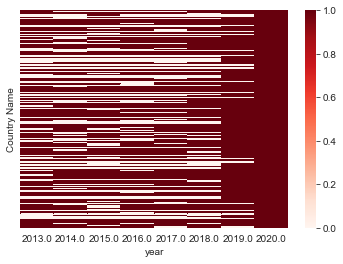

In [52]:
df_gini=pd.read_csv('Data/gini_clean.csv').iloc[:,1:]

countries_gini=df_gini['Country Name'].unique()
#display(countries_gini[~pd.Series(countries_gini).isin(countries_index)])
#display(countries_index[~pd.Series(countries_index).isin(countries_gini)])

df_gini.replace({
    'Micronesia, Fed. Sts.':'Micronesia',
    'Iran, Islamic Rep.':'Iran',
    'Kyrgyz Republic':'Kyrgyzstan',
    'Russian Federation':'Russia',
    'Korea, Rep.':'South Korea',
    'Yemen, Rep.':'Yemen',
    'Cote d\'Ivoire':'Ivory Coast',
    'Egypt, Arab Rep.':'Egypt',
    'St. Lucia':'Saint Lucia',
    'Lao PDR':'Laos'
},inplace=True)
countries_gini=df_gini['Country Name'].unique()
#display(countries_gini[~pd.Series(countries_gini).isin(countries_index)])


#merge with dataset
df_final=df_final.merge(right=df_gini[['key','gini']],how='left',on='key')

#percent of dataset with gini
percent_null=df_final[['gini']].apply(lambda x: x.isnull().sum()/ len(x),axis=1)
country=df_final['Country Name']
year=df_final['year']
conutry_year_pivot_nulls=pd.concat([country,year,percent_null],axis=1).pivot_table(index='Country Name',columns='year',values=0).fillna(1)

#plt.figure(figsize=(10,8))
sns.heatmap(conutry_year_pivot_nulls,
            yticklabels=[], #conutry_year_pivot_nulls.index, 
            cmap='Reds');

print('%Complete total',round(
    df_final['gini'].notnull().sum()/df_final['gini'].shape[0],2))
print('%Complete <2019',
      round(df_final.loc[df_final.year<2019,'gini'].notnull().sum()/df_final.loc[df_final.year<2019,'gini'].shape[0] ,2))



<a id='quality'></a>
## Data Quality

The next step is to analyze the composition of the dataset and add some new useful variables. 

With a first look at the null values, we can identify that there are many more countries in the Index than in th World Happiness report. There are also some Index variables that have values only for most recent years (2017 onwards). For the exploratory analysis I will not impute missing values now, but before running the regression this issue will have to be dealt with. 

### Null Analysis

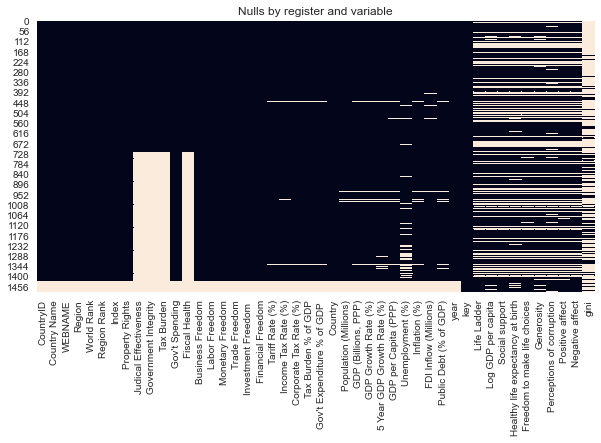

In [53]:
plt.figure(figsize=(10,5))
sns.heatmap(df_final.isnull(), cbar=False,xticklabels=df_final.columns)
plt.title('Nulls by register and variable');

### Economic Freedom Index Categories

The Economic Freedom Index has 12 measures that can be grouped into 4 categories:

- Rule of Law (composed by Property Rights, Judical Effectiveness, Government Integrity)
- Government Size (composed by Tax Burden, Gov't Spending, Fiscal Health)
- Regulatory Efficency (composed by Business Freedom, Labor Freedom, Monetary Freedom)
- Open Markets (composed by Trade Freedom, Investment Freedom, Financial Freedom)

I'll add the mean values for each of these categories, as it may simplify the analysis later on. 


In [54]:
#group variables
rule_of_law=['Property Rights','Judical Effectiveness','Government Integrity']
gov_size=['Tax Burden','Gov\'t Spending','Fiscal Health']
reg_eff=['Business Freedom','Labor Freedom','Monetary Freedom']
open_mark=['Trade Freedom','Investment Freedom ','Financial Freedom']

#add category means
df_final['Rule of law']=df_final[rule_of_law].apply(lambda x: np.average(x), axis=1)
df_final['Government Size']=df_final[gov_size].apply(lambda x: np.average(x), axis=1)
df_final['Regulatory Efficency']=df_final[reg_eff].apply(lambda x: np.average(x), axis=1)
df_final['Open Markets']=df_final[open_mark].apply(lambda x: np.average(x), axis=1)


### Region redefinition

It seems to be convenient to redefine the Regions to better reflect socio-economical similarities. For example, instead of having a region for 'Americas', divide it in 'Latin America & Caribbean' and 'North Americas & ANZ (Australia and New Zealand)' which share much more similarities. 

The resulting Regions are:
- Western Europe
- Eastern Europe
- North America & ANZ
- Latin America & Caribbean
- Arab States Persian Gulf & Israel
- Middle East and North Africa'
- Sub-Saharan Africa
- Asia Pacific


By redefining the regions, the differences become more clear.


In [55]:
#keep original region
original_region=df_final['Region'].copy()

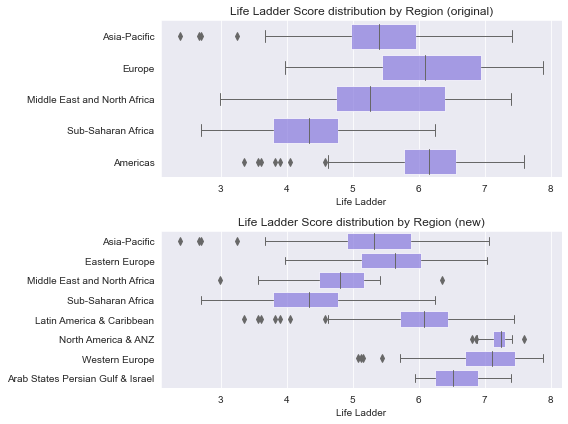

In [56]:
fig,ax=plt.subplots(2,1,figsize=(8,6))

#plot original scores by region
plot_box(y=original_region,x=df_final['Life Ladder'],ax=ax[0],orient='h',plot_style={'color':'MediumSlateBlue'})
ax[0].set(title= 'Life Ladder Score distribution by Region (original)', ylabel='')

#Redefine regions

#Western & Eastern Europe
we_countries=['Germany','United Kingdom','France','Italy','Spain','Netherlands','Belgium','Portugal','Sweden','Austria','Switzerland','Denmark','Finland','Norway','Ireland','Luxembourg','Iceland']
df_final.loc[df_final['Country Name'].isin(we_countries),'Region']='Western Europe'
df_final.loc[df_final['Region']=='Europe','Region']='Eastern Europe'

#NA & NAZ, LAtin America & Caribbean
na_countries=['Canada','United States','Australia','New Zealand']
df_final.loc[df_final['Country Name'].isin(na_countries),'Region']='North America & ANZ'
df_final.loc[df_final['Region']=='Americas','Region']='Latin America & Caribbean'
# df_americas=df_final[df_final['Region']=='Latin America & Caribbean']
# mask=~df_americas['Country Name'].isin(['Saint. Lucia', 'Saint. Vincent and the Grenadines',
#        'Bahamas, The', 'Saint Vincent and The Grenadines','Saint Lucia',
#        'Saint Vincent and the Grenadines', 'Suriname',
#        'Trinidad and Tobago','Barbados','Bahamas'])
# df_final.loc[df_americas[mask].index,'Region']='Latin America'

#Arab States & Israel
pg_i_countries=['Israel','United Arab Emirates','Saudi Arabia','Oman','Qatar','Bahrain','Kuwait']
df_final.loc[df_final['Country Name'].isin(pg_i_countries),'Region']='Arab States Persian Gulf & Israel'

#Asia
#east_asia_countries=['China','Korea, South', 'Japan','Korea, North','Macau','Mongolia','Hong Kong','Taiwan']
#southeast_asia_countries=['Brunei', 'Burma', 'Cambodia', 'Timor-Leste', 'Indonesia', 'Laos', 'Malaysia', 
 #'Philippines', 'Singapore', 'Thailand', 'Vietnam']
#df_final.loc[df_final['Country Name'].isin(east_asia_countries),'Region']='East Asia'
#df_final.loc[df_final['Country Name'].isin(southeast_asia_countries),'Region']='South-East Asia'
#df_final.loc[df_final['Region']=='Asia-Pacific','Region']='South Asia'

#add short name
short_names={
    'Asia-Pacific':'APac',
    'Eastern Europe':'E.Eu',
    'Middle East and North Africa': 'ME & NA',
    'Sub-Saharan Africa':'SS.Af',
    'Latin America & Caribbean': 'L.A & C',
    'North America & ANZ': 'NA & ANZ',
    'Western Europe':'W.Eu',
    'Arab States Persian Gulf & Israel': 'A.E & Is',
    'East Asia':'E.As',
    'South-East Asia':'SE.As'
}
df_final['Short Region']=df_final['Region'].map(short_names)

#plot scores by new regions
plot_box(y=df_final['Region'],x=df_final['Life Ladder'],ax=ax[1],orient='h',plot_style={'color':'MediumSlateBlue'})
ax[1].set(title= 'Life Ladder Score distribution by Region (new)', ylabel='');
plt.tight_layout()

<a id='analysis'></a>
## Exploratory Analysis

<a id='whr'></a>
### Analyzing The World Happiness Report

The World Happiness report attempts to measure the subjective well-being of the individuals in a society. For this, it uses 3 measures, __Life Evaluation, Positive emotions and Negative emotions.__

__Life Evaluation (Life Ladder).__ 
*The Gallup World Poll, which remains the principal source of data in this report, asks respondents to evaluate their current life as a whole using the image of a ladder, with the best possible life for them as a 10 and worst possible as a 0.*

__Positive emotions (Positive affect)__. *Respondents to the Gallup World Poll are asked whether they smiled or laughed a lot yesterday and whether they experienced enjoyment during a lot of yesterday. For each of these two questions, if a person says no, their response is coded as 0. If a person says yes, their response is coded as a 1.*

__Negative emotions (Negative affect)__. *Negative affect is measured by asking respondents whether they experienced specific negative emotions during a lot of the day yesterday. Negative affect, for each person, is given by the average of their yes or no answers about three emotions: worry, sadness, and anger.*

Other measurements included in the report that are used to explain variance in life evaluations are:
- GDP per Capita
- Social Support
- Healthy life expectancy
- Freedom to make life choices
- Generosity
- Perceptions of corruption

Although highly correlated, Life Ladder is not composed by the other indicators, it is an independent question in the Survey.

By taking a look at the top countries in life evaluations, it is clear that it's mainly composed by Western European and North America & ANZ countries.

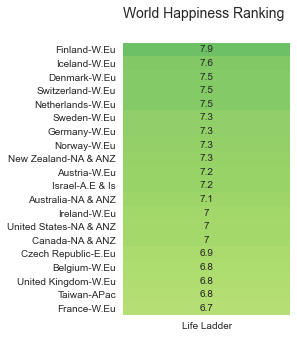

In [57]:
plt.figure(figsize=(3,5))
ranking=df_final[df_final.year==2020].sort_values(by='Life Ladder',ascending=False)[['Country Name','Short Region','Life Ladder']].set_index(['Country Name','Short Region']).head(20)
sns.heatmap(ranking,annot=True,cbar=False,vmin=0,vmax=10,cmap='RdYlGn')
plt.suptitle('World Happiness Ranking',fontsize=14);
plt.ylabel('');

In the following charts we can see the correlation of life ladder with the other variables, how each region performs in each measurement, and the evolution through the years.

In general, we can observe that Western Europe and North America & ANZ have a similar behaviour, with good scores all measures. High life evaluations, high positive emotions combined with low negative, high GDP per capita and low perceptions of corruption. 

On the lower end of life evaluations are Sub Saharan Africa and North Africa & Middle East. Both have high negative emotions and perceptions of corruption, and although positive emotions are low compared with the rest of the world, those of Sub Saharan Africa are slightly higher, even higher that other regions like Eastern Europe's. It is clear that Sub-Saharan Africa is an under developed region, with very low levels of both GDP per Capita and healthy life expectancy at birth.

Latin America has a relatively high life evaluation, especially compared with other regions that have higher levels of income. I'll be analyzing this specific region later on. 

When we look at the evolution of life evaluations, some aspects stand out. For example the steady improvement of Sub Saharan Africa, which while still one of the lowest-ranked regions, the score has risen steadily from year to year. Easter Europe is also showing strong improvement over the last years, as is Asia.

On the other hand, Latin America's life evaluation appears to be trending downward, with a particularly steep decline in 2020. Other declining regions are the Middle East & North Africa and North America & ANZ (Although it remains the highest ranked).

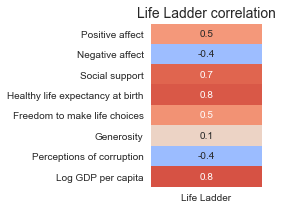

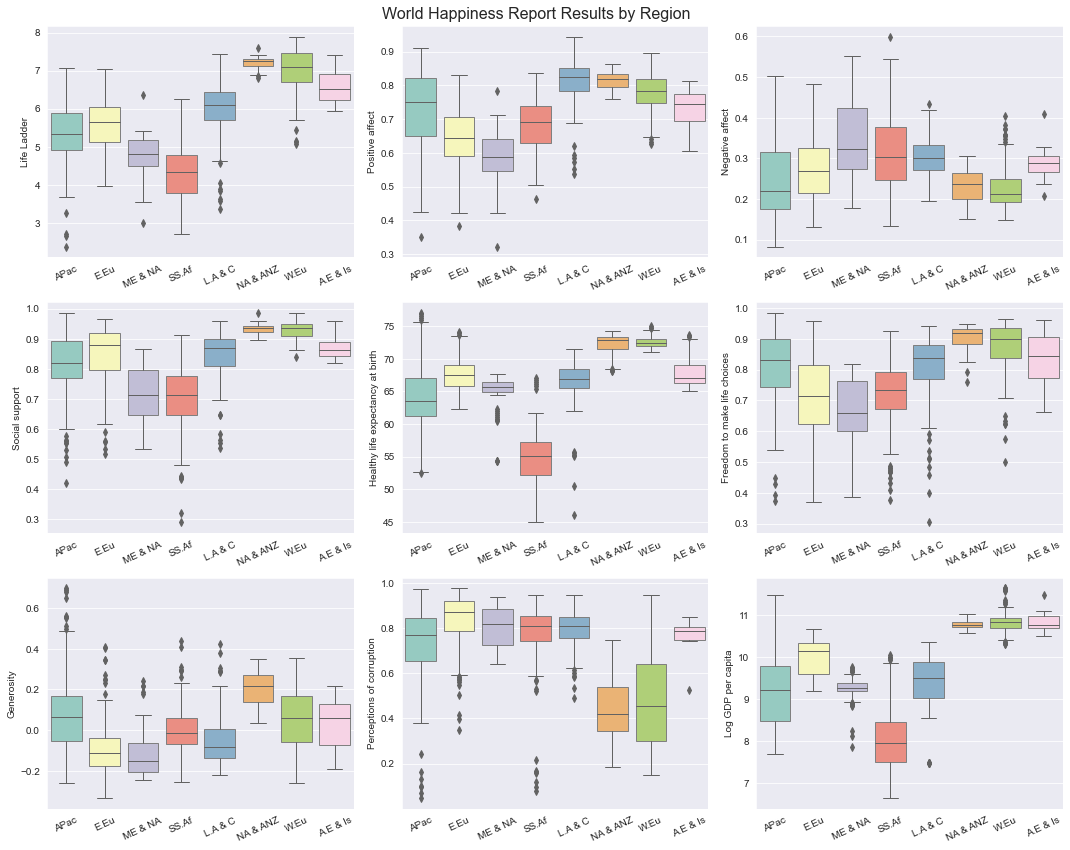

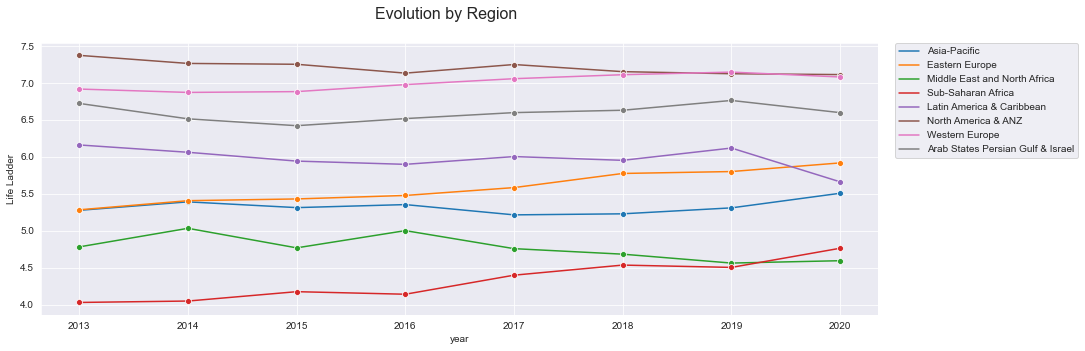

In [58]:
world_happiness_variables=['Life Ladder','Positive affect','Negative affect','Social support','Healthy life expectancy at birth','Freedom to make life choices','Generosity','Perceptions of corruption','Log GDP per capita']
hapiness_data= df_final[world_happiness_variables]

#Correlations
plt.figure(figsize=(2,3))
plt.title('Life Ladder correlation',fontsize=14)
sns.heatmap(hapiness_data.corr().iloc[1:,:1], center=0, cmap='coolwarm',vmax=1,cbar=False, annot=True,fmt='.1f');


#Results by region
#agregar a la funcion el orden
region_order=df_final.groupby(['Short Region']).mean()['Life Ladder'].sort_values(ascending=False).index

color_plots={'palette':'Set3','alpha':1,'edgecolor':'gray'}

fig,ax=plt.subplots(3,3,figsize=(15,12))
fig.suptitle('World Happiness Report Results by Region',fontsize=16)
row=0
col=0
for i in hapiness_data.columns:
    plot_box(y=hapiness_data[i],x=df_final['Short Region'],ax=ax[row,col],orient='v',
             plot_style=color_plots)
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(),rotation=25)
    ax[row,col].set_xlabel('')
    row,col=update_counters(2,row,col)
plt.tight_layout()

#Evolution
plt.figure(figsize=(15,5))
sns.lineplot(data=df_final,x='year',y='Life Ladder',hue='Region',estimator='mean',
             marker='o',ci=None);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
plt.suptitle('Evolution by Region',fontsize=16);

#### What about latin america?

It is interesting that Latin America has an unusually high Life Ladder score compared with other regions. Although the score is lower than that of 'first world' regions, it is still higher than others with similar or even greater GDPs. Latin America is also the region with the highest Positive Affect. Maybe this isn't so surprising, as latinos are known for displaying a lot of emotions. The 2018 report <a href="https://s3.amazonaws.com/happiness-report/2018/CH6-WHR-lr.pdf" target="_blank">has a whole chapter titled 'Happiness in Latin America Has Social Foundations'</a> with an interesting study of how socio-cultural structures in latin america influence happiness in the region.

The chapter argues that high happiness in Latin America may be explained by the abundance of family warmth and other supportive social relationships. Happiness research has shown that relationships are important for people’s happiness, and that positive relationships are abundant in Latin America. Hence, happiness in Latin America has social foundations. 

The patterns of personal relations in Latin America are quite different from those in other regions of the world. This leads to Latin Americans enjoying high levels of family satisfaction and experiencing many daily positive emotions. The family also has more predominance in the purpose of life of Latin Americans, so that the high scores in life evaluation may be explained in part by the success of family relations.

Nevertheless, Latin America is far from ideal. It suffers from high corruption levels, violence rate, poverty and high income inequality. For this and maybe other reasons negative emotions are also quite high, even above the world average.

Latin America seems like a region of contrasts, where family and social relations might help compensate for regional socio-economic problems. 


![SegmentLocal](latina.gif "segment")

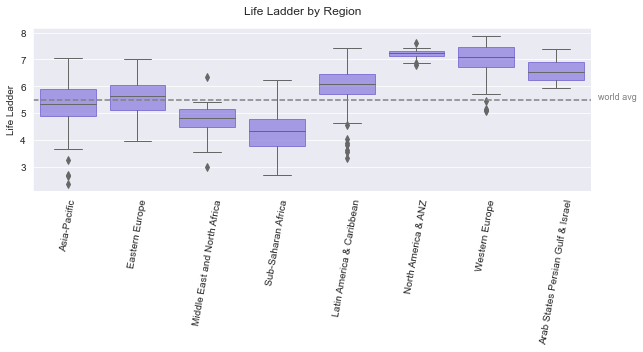

In [59]:
plt.figure(figsize=(10,3))
plt.suptitle('Life Ladder by Region')
purple_plots={'color':'MediumSlateBlue','alpha':0.7,'edgecolor':'SlateBlue'}

plot_box(y=df_final['Life Ladder'],x=df_final['Region'],ax=None,orient='v',
        plot_style=purple_plots)
plt.xticks(rotation=80)
plt.axhline(df_final['Life Ladder'].mean(), ls='--',color='gray')
ax=plt.gca()
ax.annotate(text='world avg', xy=(7.6,5.5), xycoords='data',color='gray',annotation_clip=False,fontsize=9);
plt.xlabel('');

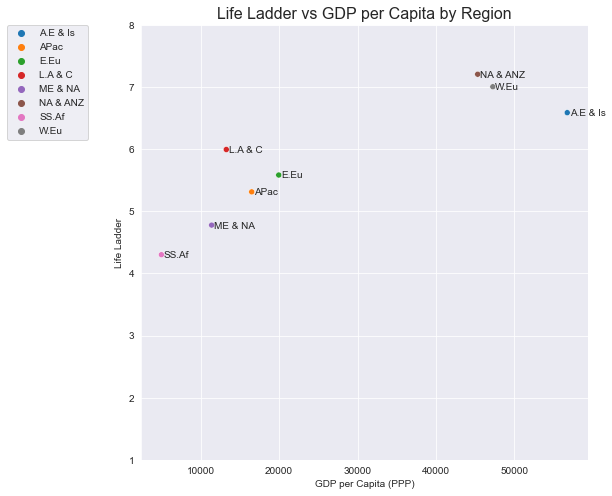

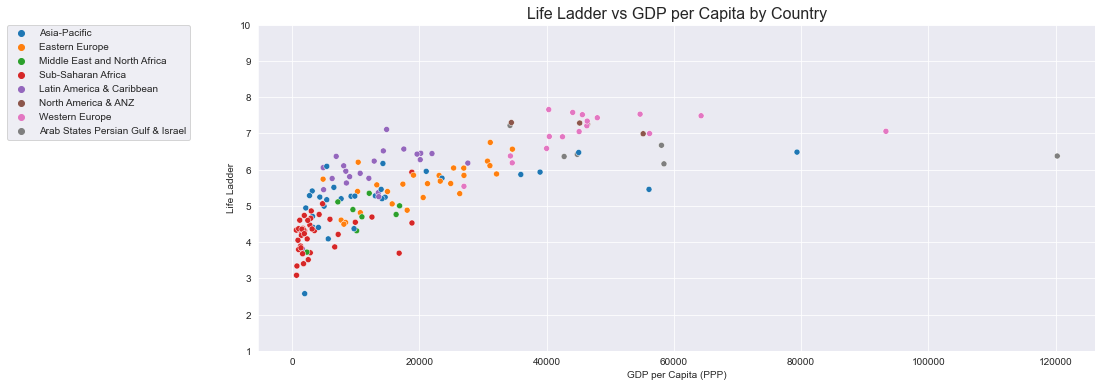

In [60]:
#Life ladder vs GDP per Capita by Region
plt.figure(figsize=(8,8))
plt.title('Life Ladder vs GDP per Capita by Region',fontsize=16)
d1=df_final.groupby(by=['Short Region']).mean()[['Life Ladder','GDP per Capita (PPP)']]
sns.scatterplot(y=d1['Life Ladder'], x=d1['GDP per Capita (PPP)'],hue=d1.index.tolist());
for i in d1.index:
    plt.annotate(text=i, xy=(d1.loc[i,'GDP per Capita (PPP)']+300, d1.loc[i,'Life Ladder']-0.05), xycoords='data');
plt.legend(bbox_to_anchor=(-0.3, 1), loc='upper left', borderaxespad=0)
plt.ylim(1,8);

#Life ladder vs GDP per Capita by Country
plt.figure(figsize=(15,6))
plt.title('Life Ladder vs GDP per Capita by Country',fontsize=16)
d1=df_final.groupby(by=['Country Name','Region']).mean()[['Life Ladder','GDP per Capita (PPP)']]
sns.scatterplot(y=d1['Life Ladder'], x=d1['GDP per Capita (PPP)'],hue=d1.index.get_level_values('Region') );
plt.legend(bbox_to_anchor=(-0.3, 1), loc='upper left', borderaxespad=0)

plt.ylim(1,10);


As noted, Latin America is the Region with the highest Positive affect, but also a relatively high Negative Affect.

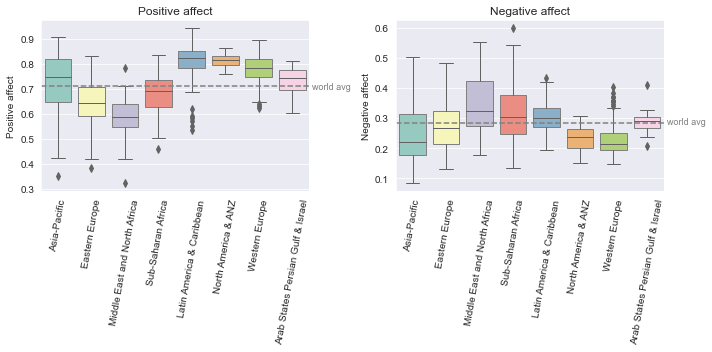

In [61]:
#Positive Affect
fig,ax=plt.subplots(1,2,figsize=(10,5))
plot_box(y=df_final['Positive affect'],x=df_final['Region'],ax=ax[0],orient='v',
        plot_style=color_plots)
ax[0].set_title('Positive affect')
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
ax[0].set_xlabel('')
ax[0].axhline(df_final['Positive affect'].mean(), ls='--',color='gray')
ax[0].annotate(text='world avg', xy=(7.6,0.7), xycoords='data',color='gray',annotation_clip=False,fontsize=9);


#Negative Affect
plot_box(y=df_final['Negative affect'],x=df_final['Region'],ax=ax[1],orient='v',
        plot_style=color_plots)
ax[1].set_title('Negative affect')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)
ax[1].set_xlabel('')
ax[1].axhline(df_final['Negative affect'].mean(), ls='--',color='gray')
ax[1].annotate(text='world avg', xy=(7.6,0.28), xycoords='data',color='gray',annotation_clip=False,fontsize=9);


plt.tight_layout()

#### Further exploration

The following chart allows interaction to discover where each country is positioned regarding to life evaluation each year. 

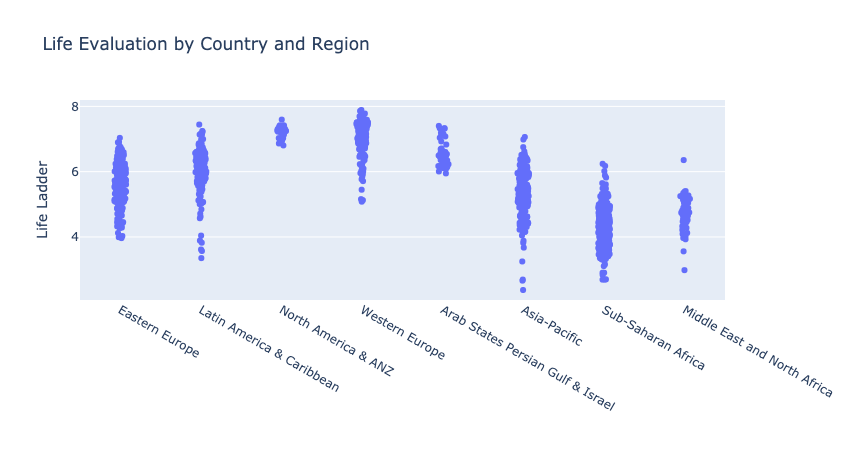

In [62]:
df_plot=df_final[['Region','Life Ladder','Country Name','year','GDP per Capita (PPP)']].dropna()
px.strip(df_plot,x='Region',y='Life Ladder',hover_data=['Country Name','year'],title='Life Evaluation by Country and Region',
         labels={ "Region": ""})


<a id='efi'></a>
### Analyzing the Economic Freedom Index

The Economic Freedom Index is an index developed by th Heritage Foundation that intends to measure the impact of liberty and free markets around the world. For this it uses 12 measures based on quantitative and qualitative factors, grouped into four broad categories, or pillars, of economic freedom:

- Rule of Law (property rights, government integrity, judicial effectiveness)
- Government Size (government spending, tax burden, fiscal health)
- Regulatory Efficiency (business freedom, labor freedom, monetary freedom)
- Open Markets (trade freedom, investment freedom, financial freedom)

Each of the twelve economic freedoms within these categories is graded on a scale of 0 to 100. A country’s overall score is derived by averaging these twelve economic freedoms, with equal weight being given to each.

An important note is that some measures have an inverse relation with what their name would indicate. For example a high score in Government Size means that there is low government prescence (low spending and taxes). This is because the index always increases as the country is more free. 


By looking at the highest ranked countries, we observe again that there are many Western European and North American & ANZ countries, but the proportion is lower than on the life evaluations, where it was 17 out of 20. 

In this case Singapore and Hong Kong appear in the highest positions, and we have more eastern european countries.

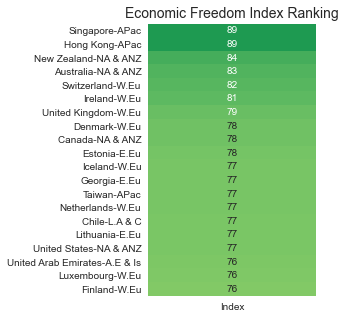

In [63]:
#Ranking: Index
plt.figure(figsize=(3,5))
plt.title('Economic Freedom Index Ranking',fontsize=14);
sns.heatmap(df_final[df_final.year==2020].sort_values(by='Index',ascending=False)[['Country Name','Short Region','Index']].set_index(['Country Name','Short Region']).head(20),annot=True,cbar=False,vmin=0,vmax=100,cmap='RdYlGn')
plt.ylabel('');


Since the Index is the sum of the other 12 measures, we expect them to be correlated. But if we map the correlations we find some interesting insights. The correlation indicates whether countries with high Index scores also have high pillar scores, as expected. Of the 4 pillars (Rule of Law, Government Size, Regulatory Efficiency and Open Markets), all but Government Size are highly correlated (0.8 and 0.9). But Government Size only has a 0.5 correlation.

Looking at each region, we see that the regions with the highest ranking in the overall index (Western Europe and North America and ANZ) actually have low scores on Government Size. Which means they have great governments.

The most unequal measure between high and low performing regions is Rule of law, which includes property rights, government integrity, and judicial effectiveness. So Western Europe and North America & ANZ have big governments, but efficient with respect to the law. 

When looking at the evolution, we see patterns similar to those in the happiness report. Asia and Eastern Europe are on an upwards trend, and Latin America and Middle East and North Africa are down. These regions reported the same pattern on the life ladder. 

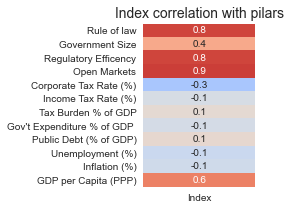

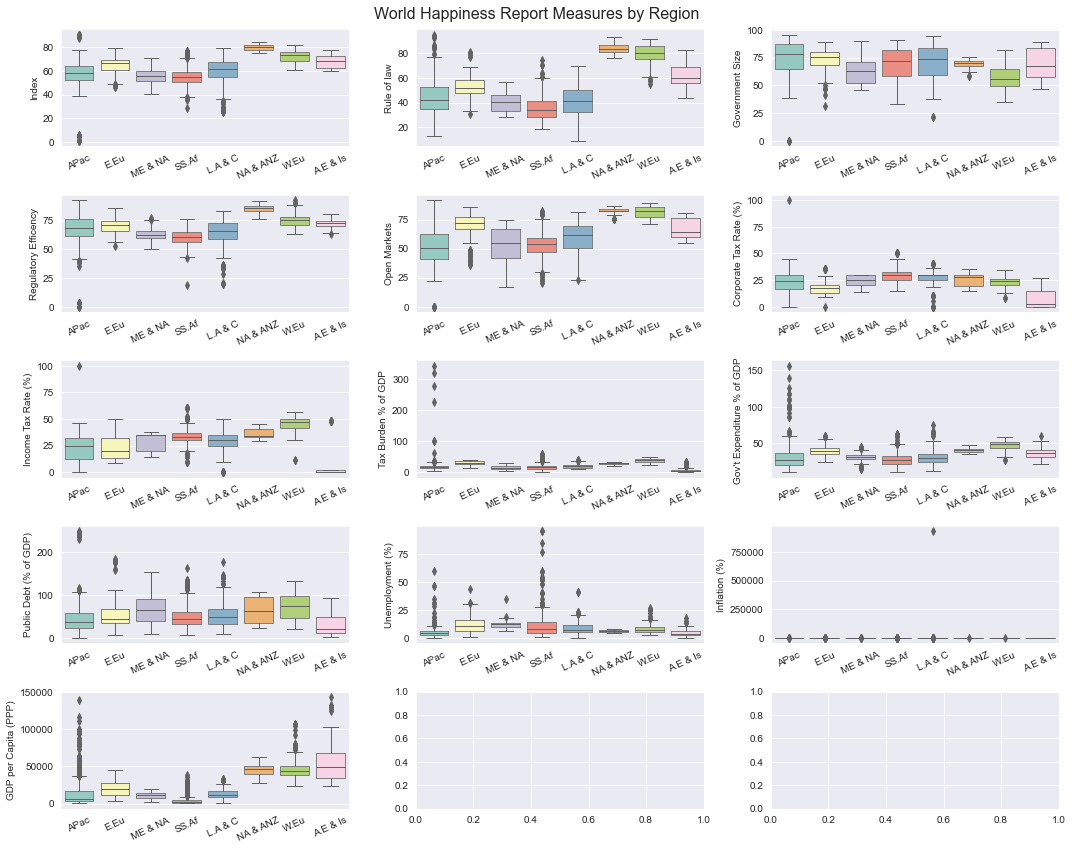

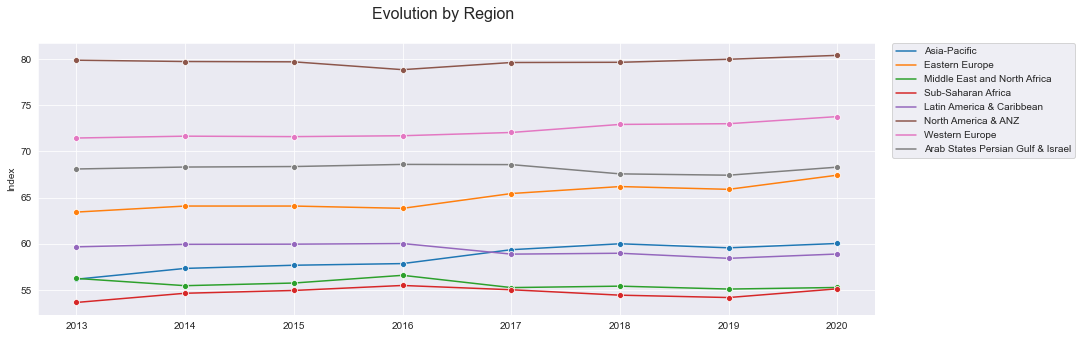

In [64]:
#Correlations
index_variables=['Index','Rule of law','Government Size','Regulatory Efficency','Open Markets','Corporate Tax Rate (%)','Income Tax Rate (%)','Tax Burden % of GDP','Gov\'t Expenditure % of GDP ','Public Debt (% of GDP)','Unemployment (%)','Inflation (%)','GDP per Capita (PPP)']
ef_data= df_final[index_variables]
plt.figure(figsize=(2,3))
plt.title('Index correlation with pilars',fontsize=14)
sns.heatmap(ef_data.corr().iloc[1:,:1], center=0, cmap='coolwarm',vmax=1,cbar=False, annot=True,fmt='.1f');

#Results by Region
columns=3
rows=math.ceil(len(index_variables)/columns)

fig,ax=plt.subplots(rows,columns,figsize=(15,12))
fig.suptitle('World Happiness Report Measures by Region',fontsize=16)
row=0
col=0
for i in ef_data.columns:
    plot_box(y=df_final[i],x=df_final['Short Region'],ax=ax[row,col],orient='v',
             plot_style={'palette':'Set3','alpha':1,'edgecolor':'gray'})
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(),rotation=25)
    ax[row,col].set_xlabel('')
    row,col=update_counters(columns-1,row,col)

plt.tight_layout()

#Evolution by Region
plt.figure(figsize=(15,5))
sns.lineplot(data=df_final,x='year',y='Index',hue='Region',estimator='mean',
             marker='o',ci=None)
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
plt.suptitle('Evolution by Region',fontsize=16);

The Index has shown over time that it is correlated with GDP per capita. Interestingly, only countries with an index greater than 60 have a per capita GDP greater than 40,000. This does not mean that all countries with index +60 have a high GDP, many do not, but the opposite is true. No country with an index below 60 achieves a per capita GDP greater than 40,000.

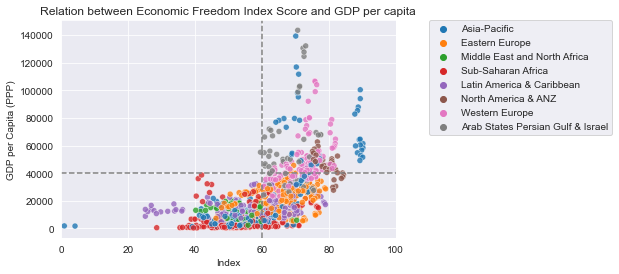

In [65]:
#Scatterplot Index vs GDP per capita
plt.title('Relation between Economic Freedom Index Score and GDP per capita')
sns.scatterplot(x=df_final['Index'], y=df_final['GDP per Capita (PPP)'],hue=df_final['Region'],alpha=0.8 );
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0);
plt.axhline(40000, ls='--',color='gray')
plt.axvline(60, ls='--',color='gray')
plt.xlim(0,100);

<a id='vs'></a>
### Happiness vs Economic Freedom Index

When we look at the relationship between the Index and Life Ladder, it appears to have a similar pattern. Only countries with an index greater than 60 have life ladders greater than 7. But especially for countries with low scores, there deoes not appear to be a clear relationship between the Index and the Life Ladder. 

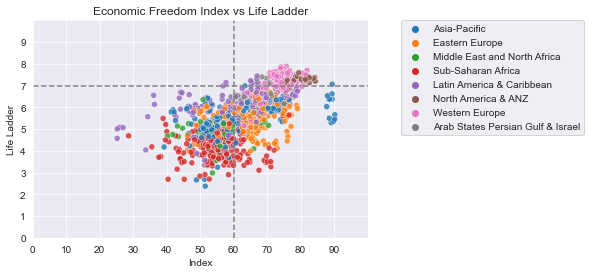

In [66]:
#Scatterplot Index vs Life ladder
plt.title('Economic Freedom Index vs Life Ladder')
sns.scatterplot(x=df_final['Index'], y=df_final['Life Ladder'],hue=df_final['Region'],alpha=0.8 );
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0);
plt.axvline(60, ls='--',color='gray')
plt.axhline(7, ls='--',color='gray')

plt.ylim(0,10)
plt.xlim(0,100)
plt.yticks(range(0,10,1))
plt.xticks(range(0,100,10));

In [67]:
#Ranking vs Percentile (Index vs Happiness)
df_2020=df_final[df_final.year==2020]
compare_ranking(df_2020,'Index','Life Ladder',10)
compare_ranking(df_2020,'Life Ladder','Index',10)
#revisar que en realidad los bottom index suelen no tener life ladder

Top  10  countries in the  Index  are on average among the  26 th percentile in the  Life Ladder .


Index  Life Ladder Percentile
Singapore        89.4          NaN        NaN
Hong Kong        89.1        5.295         60
New Zealand      84.1        7.257         20
Australia        82.6        7.137         20
Switzerland      82.0        7.508         10
Ireland          80.9        7.035         20
United Kingdom   79.3        6.798         30
Denmark          78.3        7.515         10
Canada           78.2        7.025         20
Estonia          77.7        6.453         40

Bottom 10  countries in the  Index  are on average among the  77 th percentile in the  Life Ladder .


Index  Life Ladder Percentile
Timor-Leste     45.9          NaN        NaN
Kiribati        45.2          NaN        NaN
Sudan           45.0          NaN        NaN
Zimbabwe        43.1        3.160        100
Bolivia         42.8        5.559         50
Congo, Rep.     41.8          NaN        NaN
Eritrea         38.5          NaN        NaN
Cuba            26.9          NaN        NaN
Venezuela       25.2        4.574         80
Korea, North     4.2          NaN        NaN

Top  10  countries in the  Life Ladder  are on average among the  18 th percentile in the  Index .


Life Ladder  Index Percentile
Finland            7.889   75.7         20
Iceland            7.575   77.1         20
Denmark            7.515   78.3         20
Switzerland        7.508   82.0         10
Netherlands        7.504   77.0         20
Sweden             7.314   74.9         20
Germany            7.312   73.5         20
Norway             7.290   73.4         20
New Zealand        7.257   84.1         10
Austria            7.213   73.3         20

Bottom 10  countries in the  Life Ladder  are on average among the  45 th percentile in the  Index .


Life Ladder  Index Percentile
Kenya           4.547   55.3         50
Egypt           4.472   54.0         50
Namibia         4.451   60.9         40
Myanmar         4.431   54.0         50
Benin           4.408   55.2         50
Cambodia        4.377   57.3         40
India           4.225   56.5         40
Jordan          4.094   66.0         30
Tanzania        3.786   61.7         40
Zimbabwe        3.160   43.1         60

<a id='corr'></a>
#### Correlation Analysis

By analyzing the correlations between the main variables and displaying them with a heat map, we can have a first approach to understanding the strength and direction of the relationship. Many are correlated between each other. 

Regarding Life Ladder, which is the variable that we will try to predict later, we note that some have a strong correlation (GDP per capita, index, rule of law, open markets), some moderate (positive and negative effect, regulatory efficiency) and a low one (government size).

The above is true when looking at the world as a whole. If we map these correlations within regions, some relationships change both in strength and direction. For example, in North America, GDP has a negative relationship with Life Ladder. We have to be careful not to assume that this is what *causes* the differences is happiness. In the case of North America, this negative correlation is mainly due to the US having a lower life ladder score.

Sub-Saharan Africa has very low correlations with these variables, so we wouldn't be able to have a good prediction with linear models. On the other end, Western Europe is the region with the strongest correlations. 

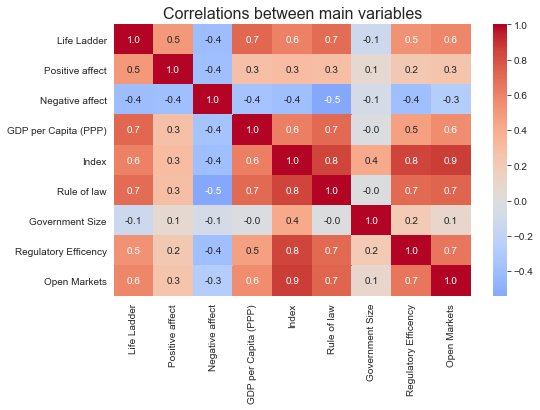

In [68]:
plt.figure(figsize=(8,5))
corr_variables=['Life Ladder','Positive affect','Negative affect','GDP per Capita (PPP)','Index','Rule of law','Government Size','Regulatory Efficency','Open Markets']
plt.title('Correlations between main variables', fontsize=16)
sns.heatmap(df_final[corr_variables].corr(), center=0, cmap='coolwarm', annot=True,fmt='.1f');

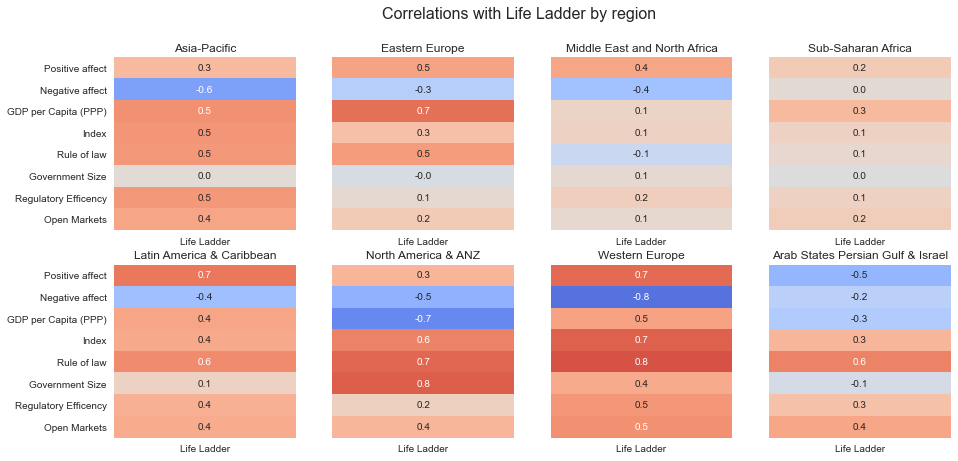

In [69]:
#Correlations by Region
regions=df_final['Region'].dropna().unique()
cols=4
rows=math.ceil(len(regions)/cols)
fig,ax=plt.subplots(rows,cols,figsize=(15,7))
fig.suptitle('Correlations with Life Ladder by region',fontsize=16)
row=0
col=0
for i in regions:
    corr_data=df_final.loc[df_final.Region==i,corr_variables].corr().iloc[1:,0:1]
    sns.heatmap(corr_data, center=0, vmin=-1, vmax=1, cmap='coolwarm', cbar=False,annot=True,fmt='.1f',ax=ax[row,col]);
    ax[row,col].set(title=i)
    if (col==0):
        ax[row,col].set()
    else:
        ax[row,col].set(yticklabels=[])
    row,col=update_counters(cols-1,row,col)

The complete correlation map between all variables can be seen below:

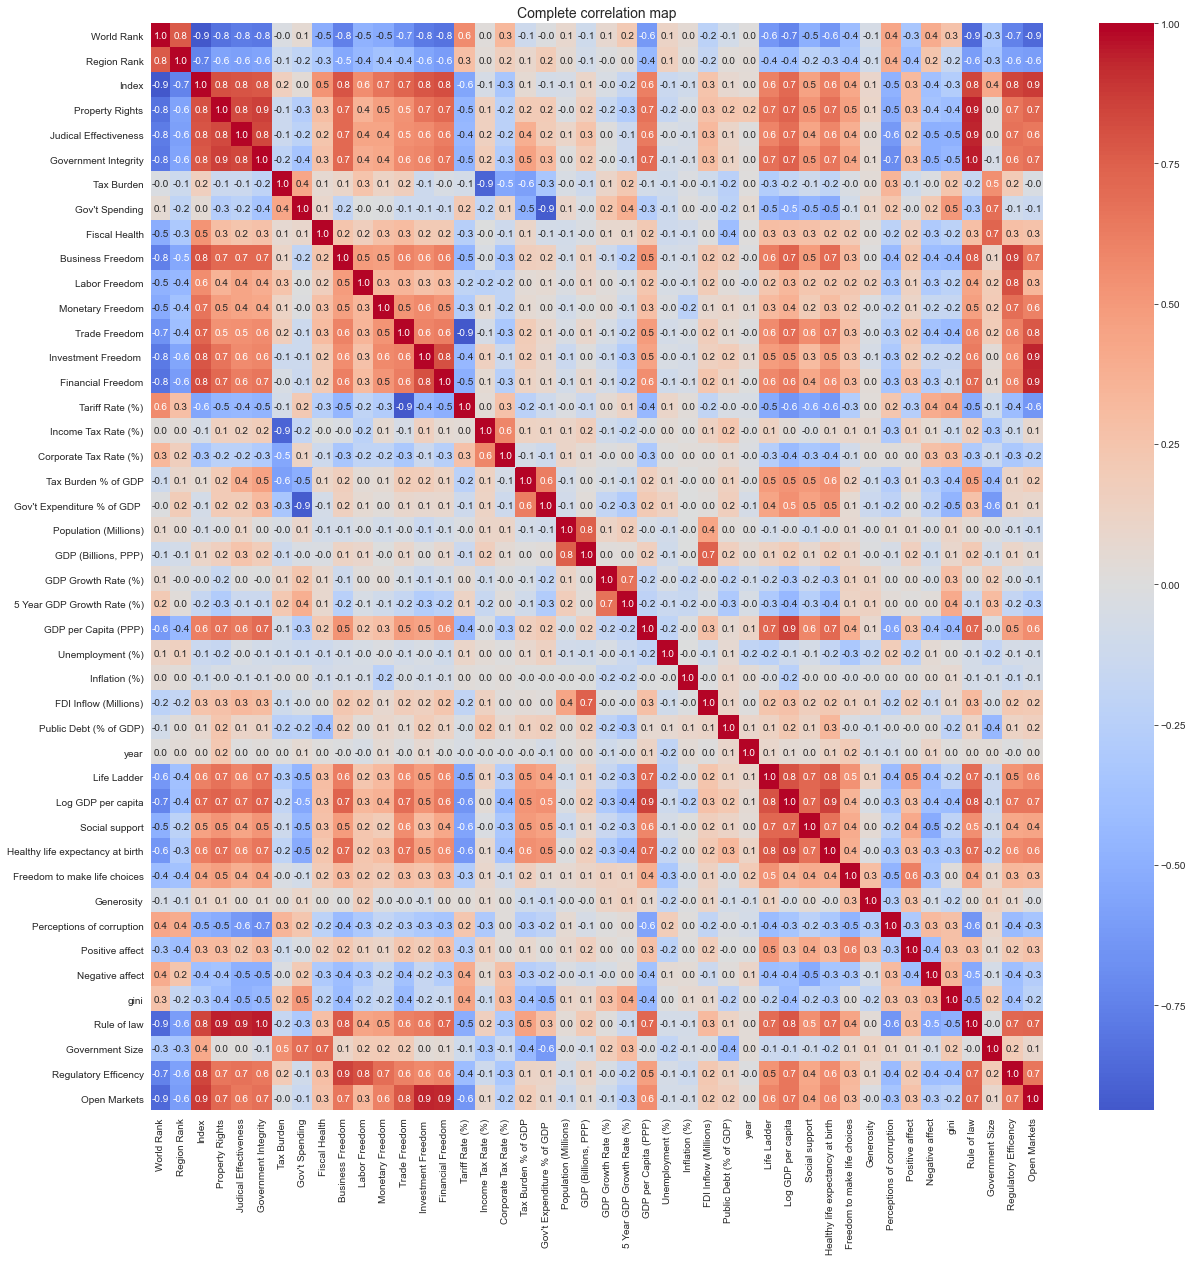

In [70]:
plt.figure(figsize=(20,20))
plt.title('Complete correlation map',fontsize=14)
sns.heatmap(df_final.iloc[:,1:].corr(), center=0, cmap='coolwarm', annot=True,fmt='.1f');

##### Further Exploration

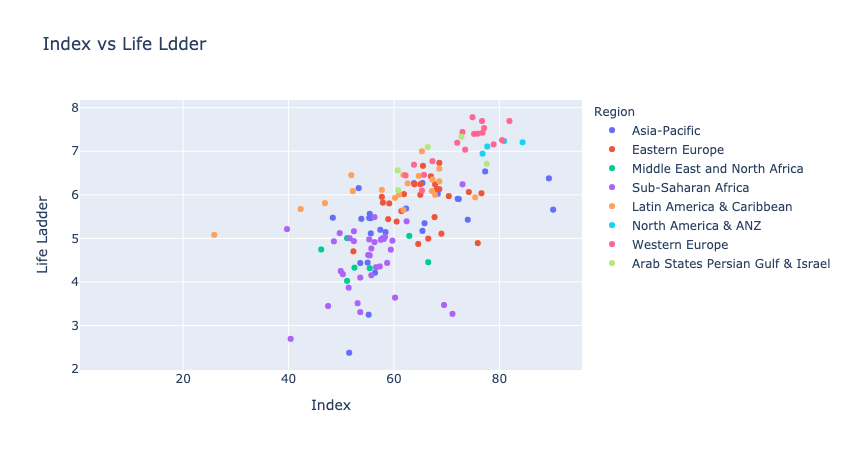

In [71]:
px.scatter(df_final.loc[df_final.year==2019],y='Life Ladder',x='Index', hover_data=['Country Name', 'year'], color='Region', title='Index vs Life Ldder')

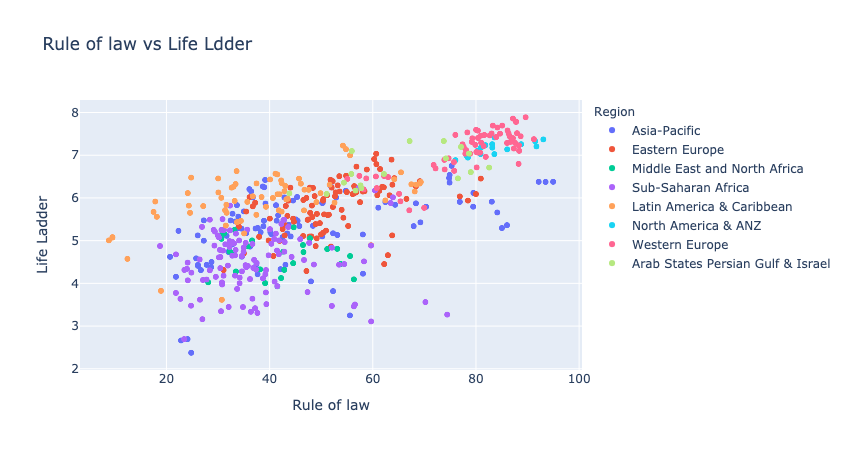

In [72]:
px.scatter(df_final.dropna(subset=['Region']),y='Life Ladder',x='Rule of law', hover_data=['Country Name', 'year'], color='Region',title='Rule of law vs Life Ldder')

#### Gini

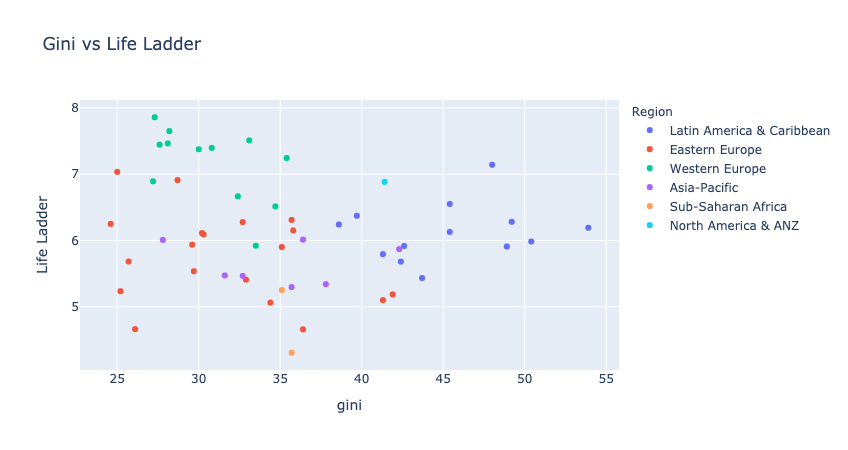

In [73]:
px.scatter(df_final[df_final.year==2018].dropna(),x='gini',y='Life Ladder', hover_data=['Country Name', 'year'], color='Region',title='Gini vs Life Ladder')

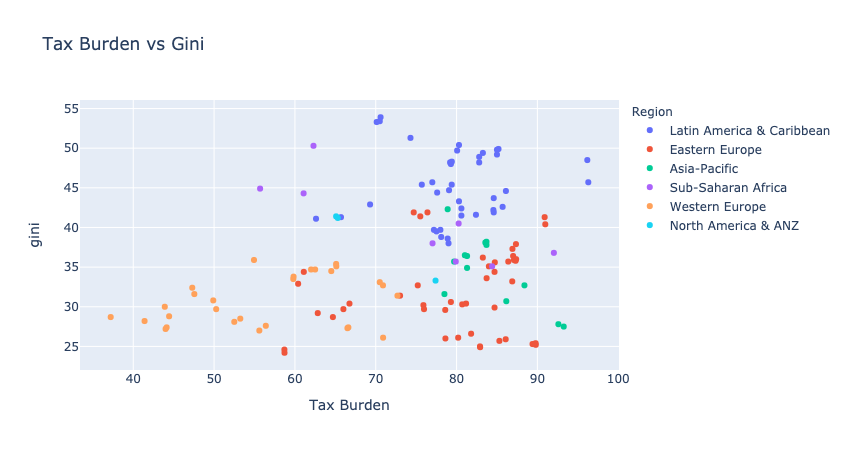

In [74]:
px.scatter(df_final.dropna(),x='Tax Burden',y='gini', hover_data=['Country Name', 'year'], color='Region',title='Tax Burden vs Gini')

<a id='clustering'></a>
#### Clustering

We'll try to identify clusters of countries with a clustermap, and interpret what these groups have in comon. For better interpretation, only a selection of countries will be included.

By using hierarchical clustering, we can identify 4 KPI groups, and 4 Country clusters:

Measures that have similar behaviors across countries can be grouped into 4 categories:
1. Government Size: Prescence of the state, for example with taxes, spending and labor freedom.
2. Government Effectiveness: Mainly Rule of law, corruption.
3. Economic Prosperity: Opneness to trade, business operations, fiscal health
4. Others: no straighforward relation

For the country clusters we identify:
- Cluster 1: Low prosperity, Low government effectiveness (Arg, Bra, India, Uga)
    - Medium/Big Gov Size: Argentina, Brasil
    - Low Gov Size: India, Uganda
- Cluster 2: High Economical Prosperity, High/Medium Government Effectiveness 
    - Big Gov: Fin, Germany, Austria, Sweden
    - Medium Gov: EEUU, Australia, Canada, Japan
    - Low Gov: Singapore
- Cluster 3: Medium/High Economical Prosperity, Large Government Size, Low Government Effectiveness
    - Greece, Italy, Spain
- Cluster 4: Medium/Low Government Size, Low/Medium Government Effectiveness, Medium Economical prosperity
    - Medium Government Effectiveness: Chile
    - Low Government Effectiveness: Peru, Colombia, Mexico
    - Low Economical prosperity: South Africa
    
    
It is interesting to note that the growth rate of GDP, but not GDP itself, is clustered with "government size". Countries with low gov size scores (meaning they have big governments) also tend to have low GDP growth rates. But at the same time they can have a high GDP, as is the example of Europe.

Fiscal health is grouped by measures of 'government effectiveness', and not by size of government (as is done in the Economic Freedom Index). We can interpret that the fiscal health of a country is more closely related to its performance under Rule of Law, than to Government Size. For example, if a government has high spending, and high rule of law, it is more likely to be in good fiscal health as well. That is the case of Western Europe. 

One possible inference could be that a country can have big government and be succesful when it keeps its fiscal health in check, and achieve high levels of the rule of law. 

<Figure size 1800x720 with 0 Axes>

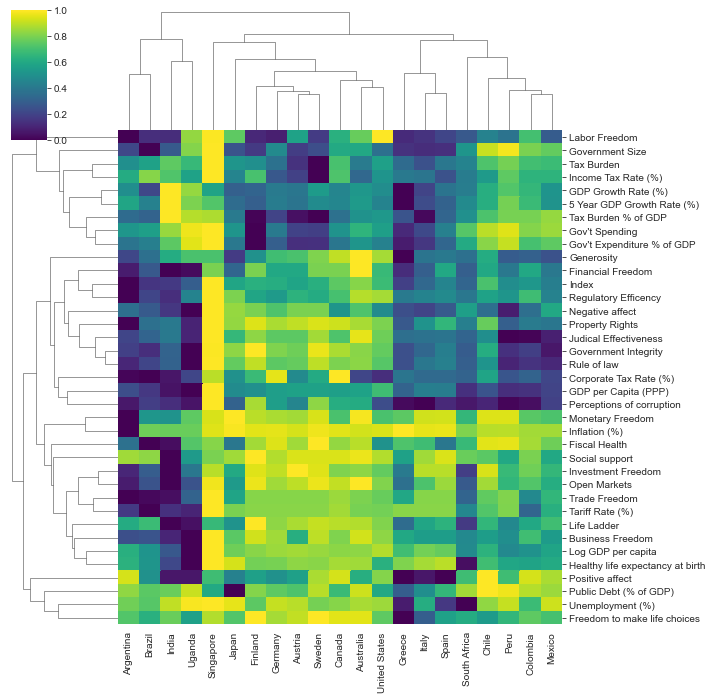

In [75]:
#select countries
countries=['Argentina','Chile','Peru','Mexico','Brazil','Colombia',
           'Spain','Finland', 'Germany','Sweden','Italy','Austria','Greece',
           'Australia','United States','Canada',
          'India','Japan','Singapore','South Africa','Uganda']

#drop columns
df_kpis=df_final.drop(columns=['WEBNAME','Region','Short Region','CountryID','World Rank','Region Rank','Population (Millions)','year','GDP (Billions, PPP)', 'FDI Inflow (Millions)','gini']).set_index('Country Name')
corr_world=df_kpis.corr()[['Life Ladder']].drop(index='Life Ladder')
df_plot=corr_world

#Invert KPIs
negatives=['Corporate Tax Rate (%)','Income Tax Rate (%)','Tariff Rate (%)','Tax Burden % of GDP','Gov\'t Expenditure % of GDP ',
'Public Debt (% of GDP)','Unemployment (%)', 'Inflation (%)','Perceptions of corruption','Negative affect']
df_kpis[negatives]=df_kpis[negatives].apply(lambda x:x*-1)

#calculate means for each country
mask_countries=df_kpis.index.isin(countries)
df_mean=df_kpis.loc[mask_countries].groupby(df_kpis[mask_countries].index).mean()
df_mean=df_mean.select_dtypes('float').round(2)

#plot clustermap
plt.figure(figsize=(25,10))
g=sns.clustermap(df_mean.T,standard_scale=0,cmap='viridis',yticklabels=df_mean.columns,xticklabels=df_mean.index);
ax = g.ax_heatmap
ax.set_xlabel('');

<a id='arg'></a>
### What's happening in Argentina?

I chose Argentina because it is the country in which I live and I have a general understanding of the socioeconomic conditions. The first thing we notice is that from 2017 to 2020 the Index score increased. But this actually has an inverse relation with the Life evaluation, which has continued to decline since 2016. 

Does this mean that Argentina has an inverse behaviour to the rest of the world?

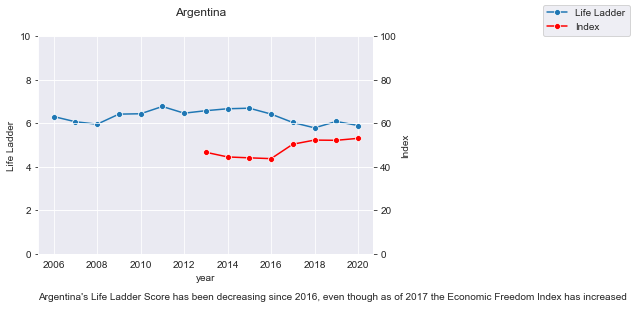

In [76]:
country='Argentina'
country_dict={
    'name':'Argentina',
    'field_1':'Country Name'
}
    
#life vs index
plt.annotate('Argentina\'s Life Ladder Score has been decreasing since 2016, even though as of 2017 the Economic Freedom Index has increased',
            xy = (0, -0.2), xycoords='axes fraction', ha='left', va="center", fontsize=10);
lineplot_2_kpis(country_dict=country_dict,kpi1='Life Ladder',kpi2='Index',df1=df_happiness,df2=df_final,ylim1=(0,10),ylim2=(0,100));


Well, probably not. Argentina is one of the few countries in the world with a high inflation problem. In 2015 (which is the index score for 2016) inflation rose to 40%, and in 2018 it reached 60%. The median inflation for the world is 3%.

The improvements in economic freedom did not stop inflation, so the quality of life of Argentines continued to deteriorate.

max           mean            std
Country Name                                              
Venezuela         929789.500  116425.460875  328648.896437
Sudan                 63.293      32.585750      21.672655
Belarus               59.218      23.131500      21.058379
Argentina             58.400      26.614250      16.922521
Suriname              55.500      14.917250      17.862579
Ukraine               48.700      13.540250      15.287149
Congo, Dem. Rep.      41.500      15.115000      15.059638
Iran                  35.200      20.572500      10.535061
Angola                32.378      16.733500      10.162097
Malawi                27.706      18.085125       7.504911

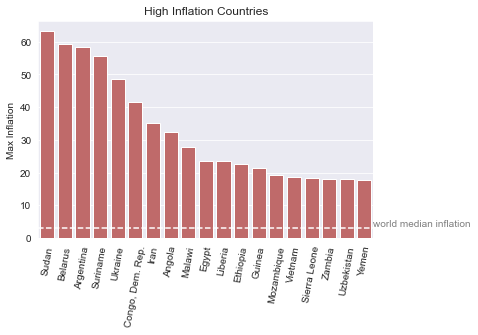

In [77]:
top_inflation=df_final.groupby('Country Name')['Inflation (%)'].agg(['max','mean','std']).sort_values(by='max',ascending=False).head(20)
display(top_inflation.head(10))
sns.barplot(data=top_inflation.drop(index='Venezuela'),
            x=top_inflation.drop(index='Venezuela').index,
            y='max',
           color='IndianRed')
plt.axhline(np.median(df_final['Inflation (%)'].dropna()), ls='--',color='white')
plt.annotate(text='world median inflation', xy=(18.5,3.5), xycoords='data',color='gray',annotation_clip=False)
plt.title('High Inflation Countries')
plt.ylabel('Max Inflation')
plt.xlabel('')
plt.xticks(rotation=80);

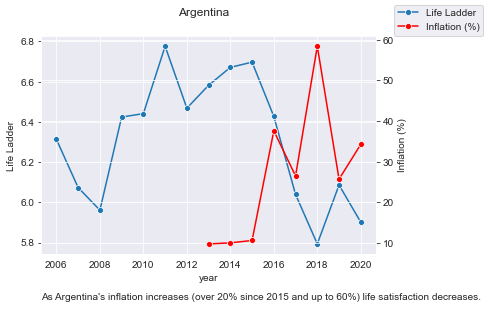

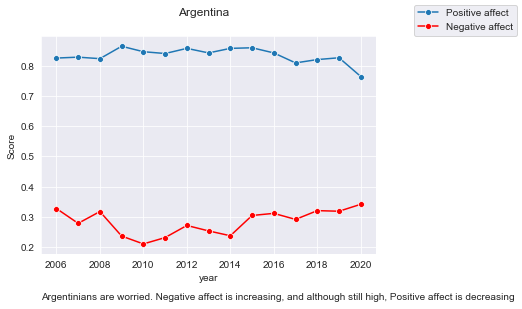

In [78]:

#life vs inflation
plt.annotate('As Argentina\'s inflation increases (over 20% since 2015 and up to 60%) life satisfaction decreases.',
            xy = (0, -0.2), xycoords='axes fraction', ha='left', va="center", fontsize=10);
lineplot_2_kpis(country_dict,'Life Ladder','Inflation (%)',df_happiness,df_final);
plt.show()


#positive and negative affect
plt.annotate('Argentinians are worried. Negative affect is increasing, and although still high, Positive affect is decreasing',
            xy = (0, -0.2), xycoords='axes fraction', ha='left', va="center",fontsize=10);

ax,ax2=lineplot_2_kpis(country_dict,'Positive affect','Negative affect',df_happiness,df_happiness,second_axis=False)
ax.set_ylabel('Score')
plt.show()


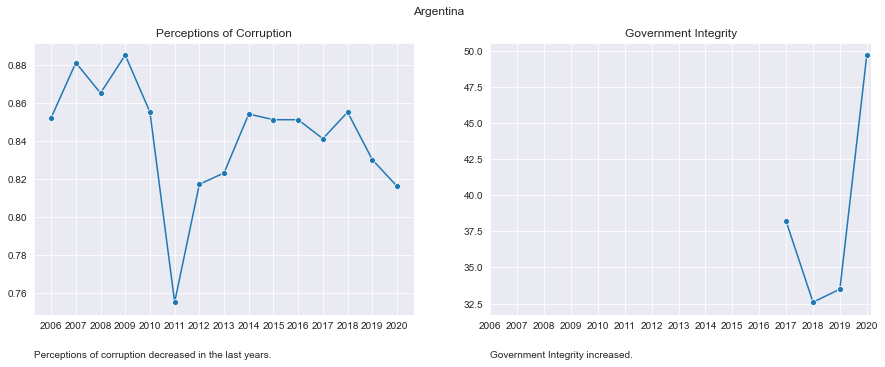

In [79]:
#Perceptions of corruption
fig,ax=plt.subplots(1,2,figsize=(15,5))
plt.suptitle(country);

sns.lineplot(data=df_happiness[df_happiness['Country Name']=='Argentina'],x='year',y='Perceptions of corruption'
             ,marker='o',ax=ax[0])
ax[0].set(title='Perceptions of Corruption',ylabel='',xlabel='')
ax[0].set_xticks(np.arange(2006, 2021,1 ));
ax[0].annotate('Perceptions of corruption decreased in the last years.',
            xy = (0, -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=10);
#Government integrity
sns.lineplot(data=df_final[df_final['Country Name']=='Argentina'],x='year',y='Government Integrity'
             ,marker='o',ax=ax[1])
ax[1].set_xticks(np.arange(2006, 2021,1));
ax[1].set(title='Government Integrity',ylabel='',xlabel='')
ax[1].annotate('Government Integrity increased.',
            xy = (0, -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=10);

Looking at the pillars of the index, we see that open markets and rule of law had a substantial increase, but the score in size of government decreased. This is explained by the abrupt fall of Fiscal Health caused by the increase in Public Debt and the fall in GDP.

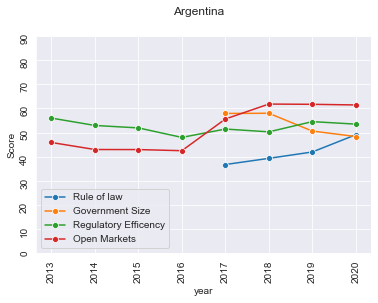

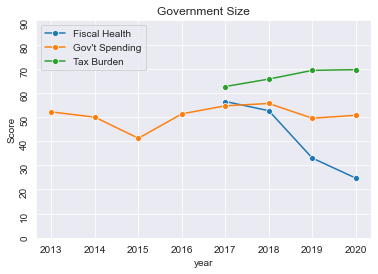

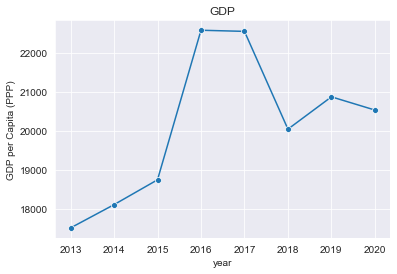

In [80]:
#Evolution categories index
fig,ax=plt.subplots(1,1)
for i in ['Rule of law','Government Size','Regulatory Efficency','Open Markets']:
    sns.lineplot(data=df_final[df_final['Country Name']==country],x='year',y=i
             ,marker='o', ax=ax, label=i)
plt.ylabel('Score')

plt.xticks(np.arange(2013, 2021,1 ),rotation='vertical');
plt.yticks(np.arange(0, 100,10),rotation='vertical');
plt.legend(loc='lower left')
plt.suptitle(country);

plt.figure()
plt.title('Government Size')
for i in ['Fiscal Health','Gov\'t Spending','Tax Burden']:
    sns.lineplot(data=df_final[df_final['Country Name']==country],x='year',y=i
             ,marker='o',  label=i)
plt.ylabel('Score')
plt.yticks(np.arange(0, 100,10),rotation='vertical');

plt.figure()
plt.title('GDP')
sns.lineplot(data=df_final[df_final['Country Name']==country],x='year',y='GDP per Capita (PPP)'
             ,marker='o');

<a id='regression'></a>
## Linear Regression Model

Finally, I will try to build a linear regression model to see to what extent the variables seen above can explain the life evaluations for each country.

<a id='preprocessing'></a>
### Data pre-processing

In order to run the model, the dataset must not have null values. The strategies used include:
- discard the observation if it doesn´t have a target value (life ladder score) or Index score
- completing with the last value that a country has for metrics that began to be recorded in 2017

For the variables that remain with nulls, the observation will be discarded in the case it is used in the model. 

In [81]:
df_model=df_final.copy()
#Drop observations without life ladder (target score)
df_model.dropna(subset=['Life Ladder'],inplace=True)

#Drop observations without Index score
df_model.dropna(subset=['Index'],inplace=True)

#Drop fields with no value
df_model.drop(columns=['WEBNAME','Region Rank', 'Country', 'World Rank','key','CountryID'],inplace=True)
            
#drop gini as it has a high percentage of nulls
df_model.drop(columns='gini',inplace=True)

#fill values of Judical Effectiveness, Government Integrity & Tax Burden with last year for each country
list=['Country Name','Judical Effectiveness','Government Integrity','Tax Burden','Fiscal Health']
country_2017=df_final[df_final.year==2017][list]
df_model.loc[:,list]=df_model.sort_values(by=['Country Name','year'], ascending=False).loc[:,list].fillna(method='ffill')

#calculate Rule of Law y Government Size
df_model['Rule of law']=df_model[rule_of_law].apply(lambda x: np.average(x), axis=1)
df_model['Government Size']=df_model[gov_size].apply(lambda x: np.average(x), axis=1)

df_model.info()
#

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037 entries, 1 to 1430
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country Name                      1037 non-null   object 
 1   Region                            1037 non-null   object 
 2   Index                             1037 non-null   float64
 3   Property Rights                   1037 non-null   float64
 4   Judical Effectiveness             1037 non-null   float64
 5   Government Integrity              1037 non-null   float64
 6   Tax Burden                        1037 non-null   float64
 7   Gov't Spending                    1037 non-null   float64
 8   Fiscal Health                     1037 non-null   float64
 9   Business Freedom                  1037 non-null   float64
 10  Labor Freedom                     1037 non-null   float64
 11  Monetary Freedom                  1037 non-null   float64
 12  Trade 

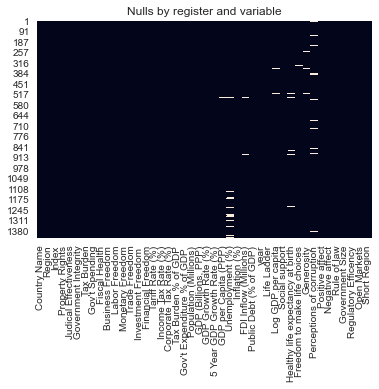

In [82]:
#check null distribution
plt.title('Nulls by register and variable')
sns.heatmap(df_model.isnull(), cbar=False,xticklabels=df_model.columns);

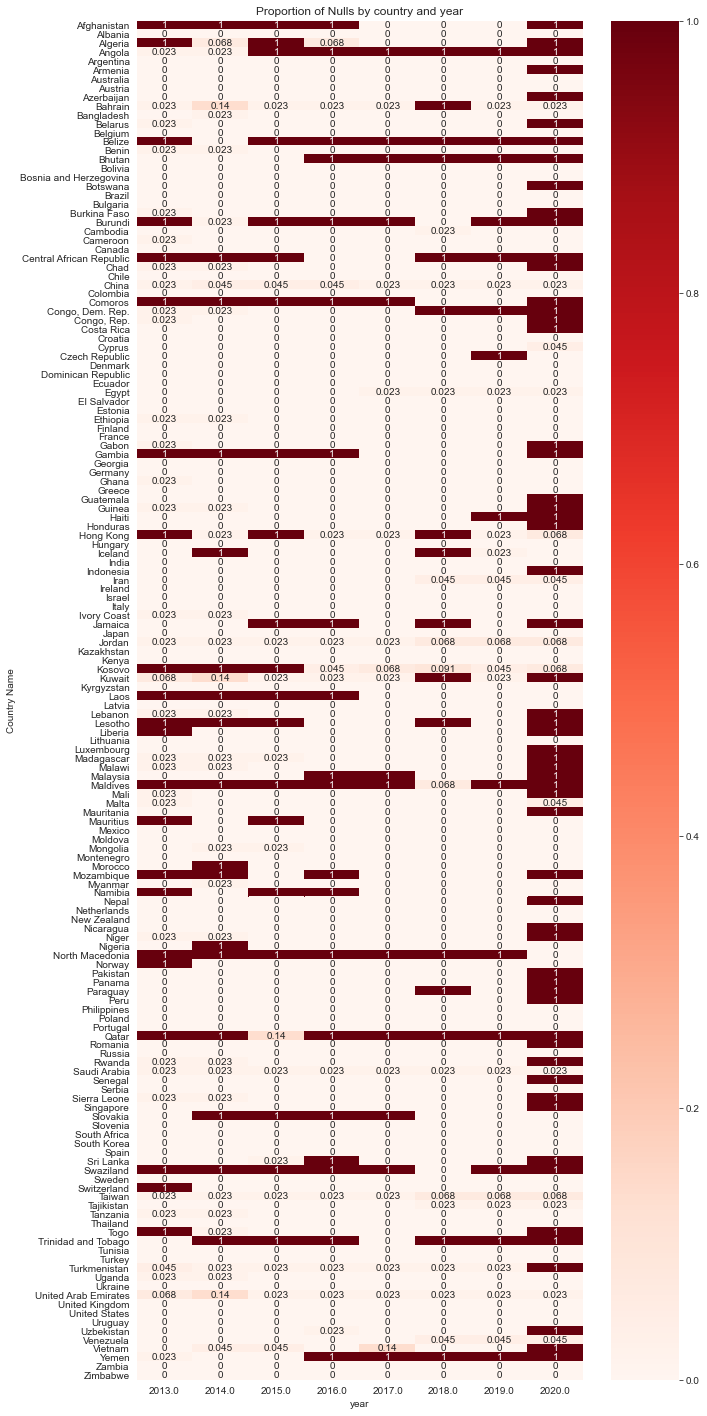

In [83]:
#null by country and year
percent_null=df_model.apply(lambda x: x.isnull().sum()/len(x),axis=1)
country=df_model['Country Name']
year=df_model['year']
country_year_pivot_nulls=pd.concat([country,year,percent_null],axis=1).pivot_table(index='Country Name',columns='year',values=0).fillna(1)

plt.figure(figsize=(10,25))
plt.title('Proportion of Nulls by country and year')
sns.heatmap(country_year_pivot_nulls,yticklabels=country_year_pivot_nulls.index, annot=True,cmap='Reds');

#### Mean scores by country

Changes in the quality of life of society will surely take several years. And most economic measures may not have an immediate impact. That is why we will use the average score of each country in the last 5 years.

In [84]:
df_mean=df_model[df_model.year>2015].groupby(['Country Name','Region']).mean().drop(columns='year')

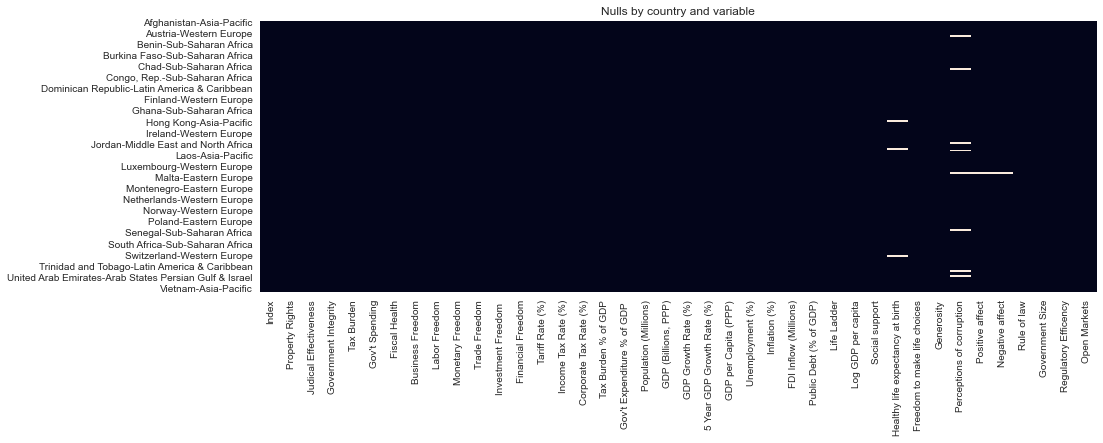

In [85]:
plt.figure(figsize=(15,5))
plt.title('Nulls by country and variable')
sns.heatmap(df_mean.isnull(), cbar=False,xticklabels=df_mean.columns)
plt.ylabel('');

<a id='feat_targ'></a>
### Features and Target

For the features we'll start by dropping some variables. As the idea is to use variables in the index, we will discard other variables that are closely related. These include those related to GDP and also some that appear in the world report on happiness. Positive and negative affect will remain as they do not have a high correlation and are a way of explaining how emotions affect life satisfaction.

In [86]:
drop_columns=[
    #drop GDP variables
    'FDI Inflow (Millions)','Log GDP per capita', 'GDP per Capita (PPP)','GDP (Billions, PPP)', 'GDP Growth Rate (%)',                        
    #drop variables from Happiness Index
    'Generosity','Freedom to make life choices', 'Social support',
    'Perceptions of corruption','Healthy life expectancy at birth',
    #drop target
    'Life Ladder',
                         ]
#drop columns
#mask=df_mean.columns.isin(drop_columns)
#mask2=df_mean.columns.isin(drop_correlated)

#Xmean=df_mean.drop(columns=df_mean.columns[mask])

#drop target, region and name from features
Xmean=df_mean.drop(columns=drop_columns)
ymean=df_mean['Life Ladder']

#check nulls
#plt.figure(figsize=(15,5))
#sns.heatmap(Xmean.isnull(), cbar=False,xticklabels=Xmean.columns);
print('Null values:', Xmean.isnull().sum().sum())

Xmean.dropna(inplace=True)
ymean=ymean[Xmean.index]
print('Shape without nulls',Xmean.shape,ymean.shape)

Null values: 2
Shape without nulls (146, 29) (146,)


#### Correlations for the resulting set of features

There are still many variables that have a high correlation. When defining the best-performing feature set for the model, this will need to be taken into account.

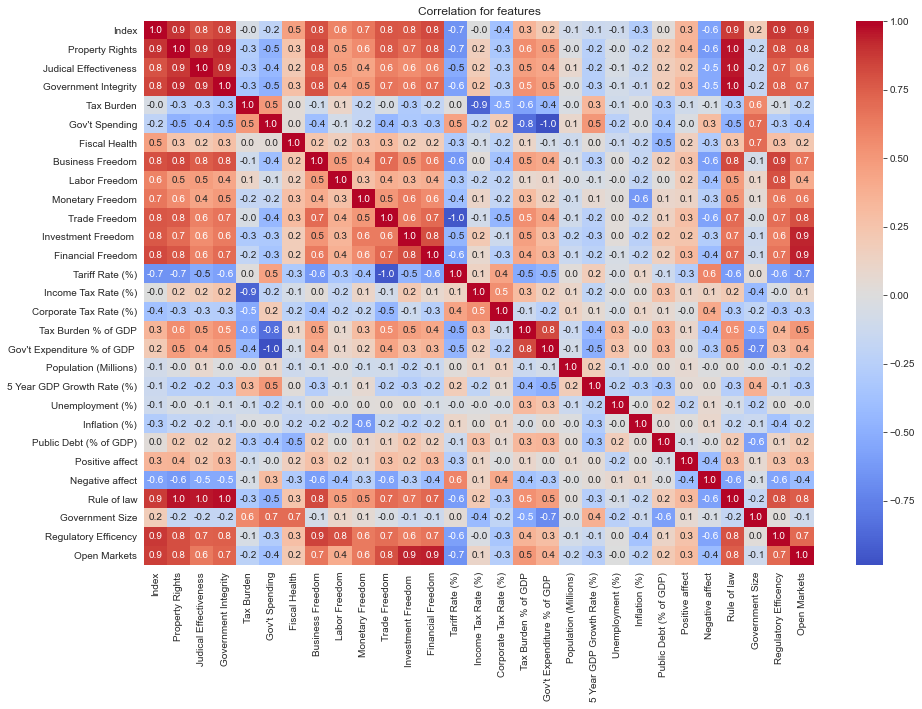

In [87]:
#correlation between features
plt.figure(figsize=(15,10))
plt.title('Correlation for features')
sns.heatmap(Xmean.corr(), center=0, cmap='coolwarm', annot=True,fmt='.1f');

The plot below can be used to understand the linear relations between each variable and the target. 

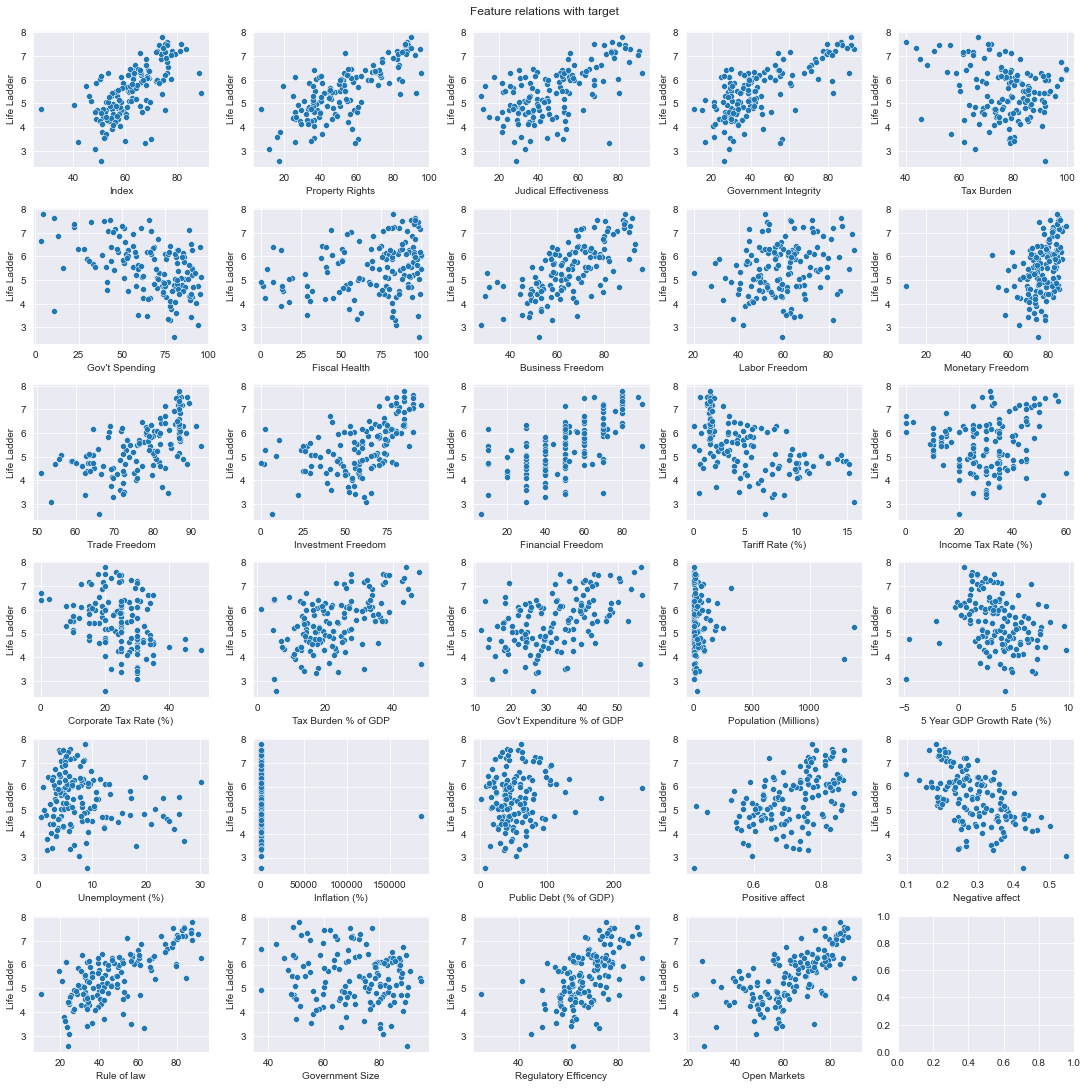

In [88]:
cols=5
rows=math.ceil(Xmean.shape[1]/cols)
col=0
row=0
fig,ax=plt.subplots(rows,cols,figsize=(15,15),constrained_layout=True)
fig.suptitle('Feature relations with target')
for i in Xmean.columns:
    sns.scatterplot(x=Xmean[i],y=ymean,ax=ax[row,col])
    row,col=update_counters(cols-1,row,col)

As seen before, Africa does not appear to have a strong linear relationship with any of the variables. That is why we exclude it from the model.

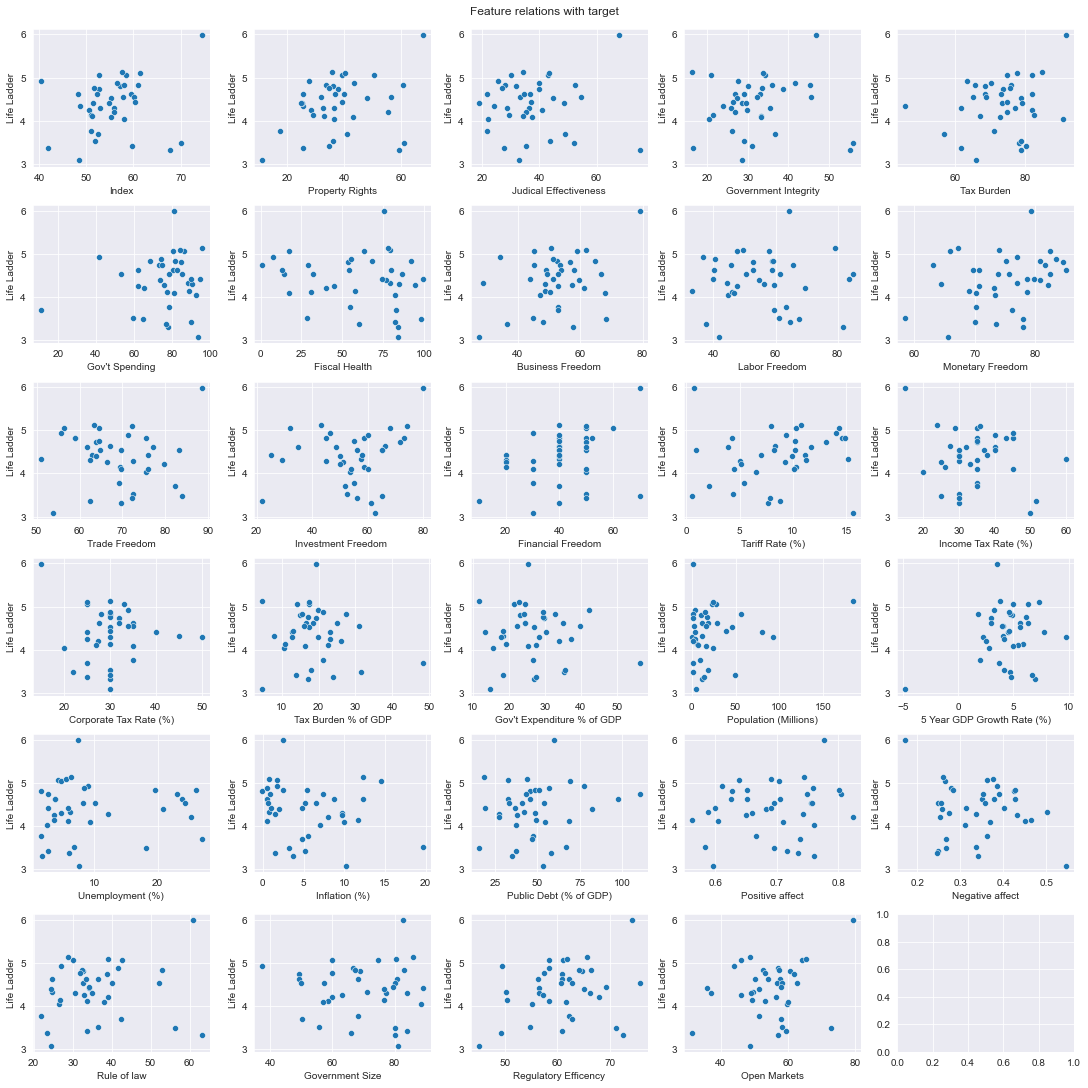

In [89]:
#df_africa=df_mean.xs('Sub-Saharan Africa',level=1)
mask_africa=Xmean.index.get_level_values('Region') == 'Sub-Saharan Africa'
cols=5
rows=math.ceil(Xmean.shape[1]/cols)
col=0
row=0
fig,ax=plt.subplots(rows,cols,figsize=(15,15),constrained_layout=True)
plt.suptitle('Feature relations with target')

for i in Xmean.columns:
    sns.scatterplot(x=Xmean.loc[mask_africa,i],y=ymean[mask_africa],ax=ax[row,col])
    row,col=update_counters(cols-1,row,col)


In [90]:
X2=Xmean[~mask_africa]
y2=ymean[~mask_africa]


Xy=pd.concat([X2,y2],axis=1)


##### Correlation with target

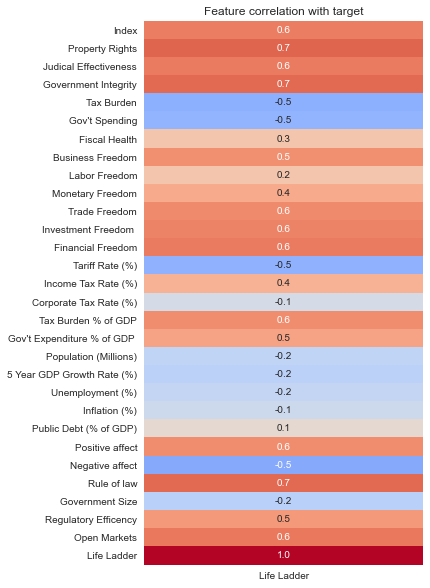

In [102]:
plt.figure(figsize=(5,10))
plt.title('Feature correlation with target')
sns.heatmap(Xy.corr()[['Life Ladder']], center=0, cmap='coolwarm', annot=True,fmt='.1f',cbar=False);

<a id='lr'></a>
###  Linear Regression Model

After trying different combinations, the final model includes 4 features.

From the Index of Economic Freedom, the score in the categories Rule of law and Government Size. Regulatory efficiency and Open Markets are ruled out because they have a high correlation with Rule of law.

From the World Report on Happiness, Positive and Negative Affect. These last two variables are included as a way to account for the cultural differences that can affect the perception of happiness.

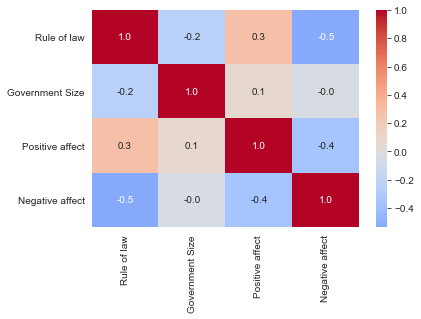

In [111]:
lr_features=[
    #'Index',
    'Rule of law', 
    'Government Size',
    #'Regulatory Efficency',
    #'Open Markets',
    #'Tax Burden',
    #'Fiscal Health',
    #'Gov\'t Spending',
    #'Business Freedom', 
    #'Labor Freedom', 
    #'Monetary Freedom',
    #'Investment Freedom ',
    #'GDP per Capita (PPP)',
    #'5 Year GDP Growth Rate (%)',
    #'Inflation (%)',
    #'Public Debt (% of GDP)',
    #'Unemployment (%)',
    'Positive affect',
    'Negative affect'
]
 
Xmean_lr=X2[lr_features].copy()
ymean_lr=y2.copy()

#take all to scale 1 to 10
div_10=['Rule of law', 'Government Size']#,'Regulatory Efficency','Open Markets']
mult_10=['Positive affect','Negative affect']
Xmean_lr[div_10]=Xmean_lr[div_10]/10
Xmean_lr[mult_10]=Xmean_lr[mult_10]*10


sns.heatmap(Xmean_lr.corr(), center=0, cmap='coolwarm', annot=True,fmt='.1f');

The linear model results in an R2 of 0.71, and Mean Absolute Error of 0.39. This means that the average absolute difference between the prediction and the real observation is less than 0.4 on a scale of 1 to 10. This is pretty close. 

In [112]:
 Xconst, linear_model,ypred=fit_linear_regression(Xmean_lr,ymean_lr);
#scaler, Xconst, linear_model,ypred=fit_linear_regression(Xmean_lr,ymean);

                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     55.03
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           9.68e-25
Time:                        12:58:09   Log-Likelihood:                -84.830
No. Observations:                 108   AIC:                             179.7
Df Residuals:                     103   BIC:                             193.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.4313      0.653     

/opt/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Comparison with model without taking into account emotions

A model that doesn't consider positive an negative emotions has a lower R2 of 0.567, which means more noise, and increases in prediction error up to RMSE=0.66 and MAE=0.50.

In [113]:
Xconst2, linear_model2,ypred2=fit_linear_regression(Xmean_lr[['Rule of law', 'Government Size',
    #'Regulatory Efficency',#'Open Markets'
                                                                      ]],ymean_lr);

                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     55.50
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           3.58e-17
Time:                        12:58:09   Log-Likelihood:                -107.62
No. Observations:                 108   AIC:                             221.2
Df Residuals:                     105   BIC:                             229.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.5009      0.424     

/opt/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



When we compare the results of the two models by region, we can see how the inclusion of positive and negative emotions affected each region differently. For this I calculate the average error and the standard deviation per region.

The Middle East and North Africa corrected the predictions from -0.74 to -0.26. As the region most affected by wars, it is understandable that the model with only variables of economic freedom could not capture the true sentiment of the region.

As we expected, Latin America reduced the average error from 0.54 to 0.18 when accounting for emotions.

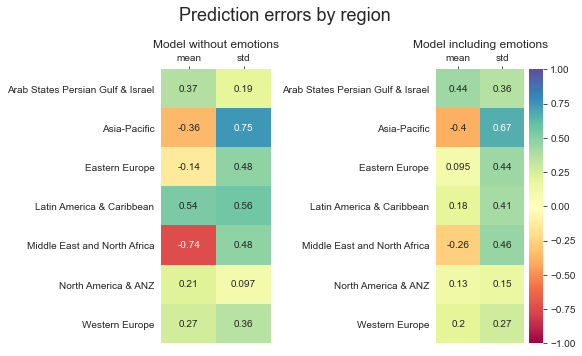

In [114]:
#results model without emotions
data_y_2=pd.DataFrame(data={'real':ymean_lr, 'pred':ypred2,'dif':ymean_lr-ypred2})
data_results_2=X2.join(other=data_y_2,how='left')
data_results_2.sort_values(by=['real'],inplace=True)
mean_mae_region_2=data_results_2.reset_index().groupby('Region').agg(['mean','std'])['dif']
#plot 
fig,ax=plt.subplots(1,2,figsize=(8,5))
sns.heatmap(mean_mae_region_2,annot=True,center=0,cmap='Spectral',cbar=False,ax=ax[0],vmax=1,vmin=-1);
ax[0].set_title('Model without emotions')
ax[0].set_ylabel('')
ax[0].xaxis.set_ticks_position('top')


#results model with emotions
data_y=pd.DataFrame(data={'real':ymean, 'pred':ypred,'dif':ymean-ypred})
data_results=Xmean.join(other=data_y,how='left')
data_results=data_results.loc[~mask_africa]
data_results.sort_values(by=['real'],inplace=True)
mean_mae_region=data_results.reset_index().groupby('Region').agg(['mean','std'])['dif']
#plot
sns.heatmap(mean_mae_region,annot=True,center=0,cmap='Spectral',cbar=True,ax=ax[1],vmax=1,vmin=-1)
ax[1].set_title('Model including emotions')
ax[1].set_ylabel('')
ax[1].xaxis.set_ticks_position('top')

fig.suptitle('Prediction errors by region',fontsize=18)
plt.tight_layout()

We will finally check the residuals for each variable, and see they are quite uniform.

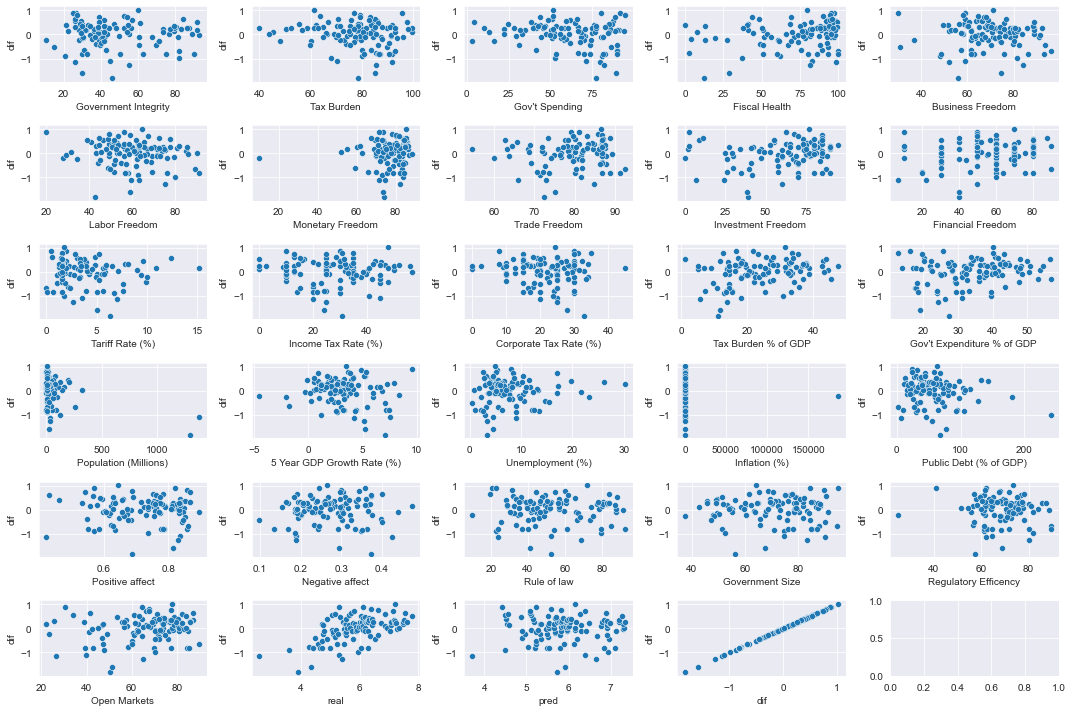

In [115]:
cols=5
rows=math.ceil(data_results.iloc[:,3:].shape[1]/cols)
col=0
row=0
fig,ax=plt.subplots(rows,cols,figsize=(15,10))
for i in data_results.columns[3:]:
    sns.scatterplot(x=data_results[i],y=data_results['dif'],ax=ax[row,col])
    row,col=update_counters(cols-1,row,col)
    plt.tight_layout()


<a id='results'></a>
### Results

The following chart lets us explore how the model aproximated the real value for each country.

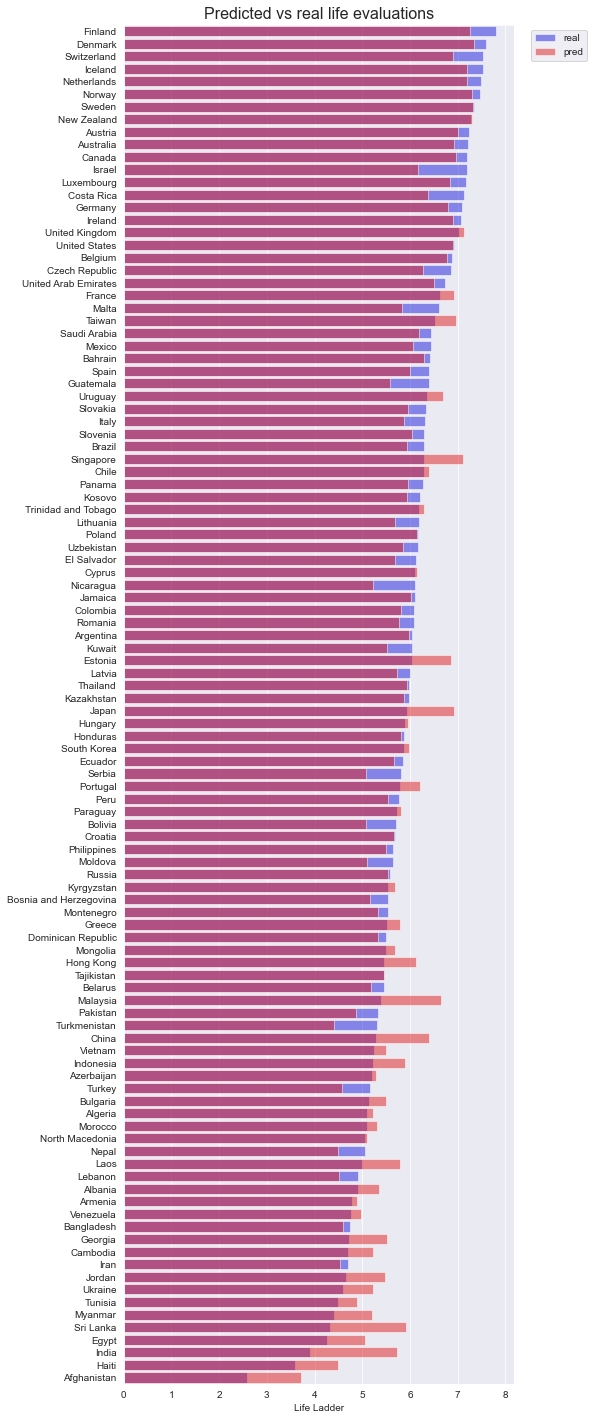

In [182]:
plt.figure(figsize=(7,25))
sns.barplot(data=data_results.reset_index().sort_values(by='real',ascending=False), x='real',y='Country Name',color='blue',alpha=0.5,label='real')
sns.barplot(data=data_results.reset_index().sort_values(by='real',ascending=False), x='pred',y='Country Name',color='red',alpha=0.5,label='pred')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1))
plt.ylabel('')
plt.xlabel('Life Ladder')
plt.title('Predicted vs real life evaluations',fontsize=16);

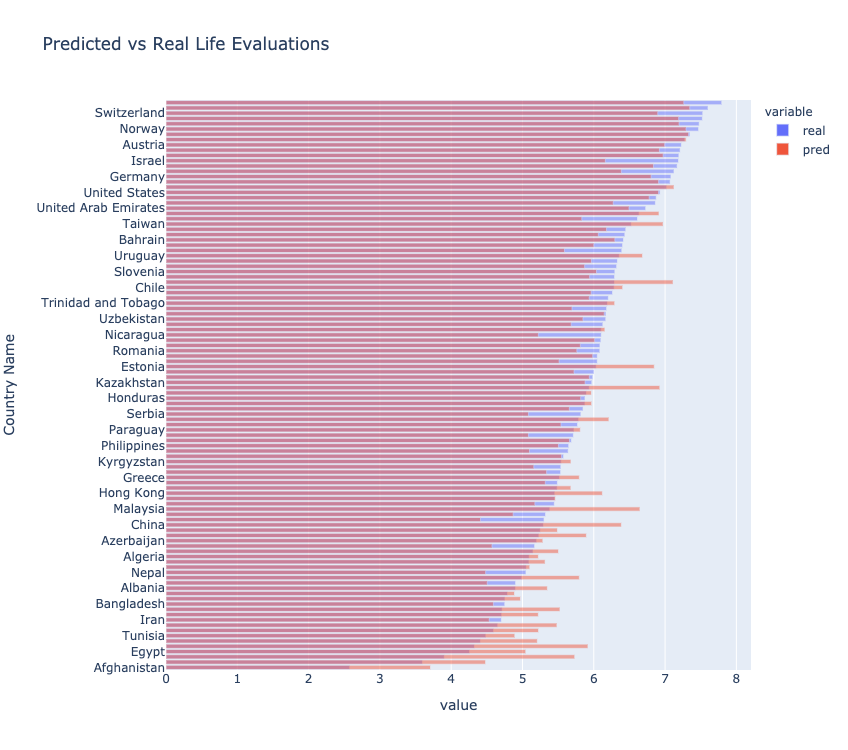

In [116]:

px.bar(data_results.reset_index(), y='Country Name',x=['real','pred'],
      orientation='h',barmode='overlay',height=750,width=800, title='Predicted vs Real Life Evaluations')



And the errors can be seen more clearly with the following chart:

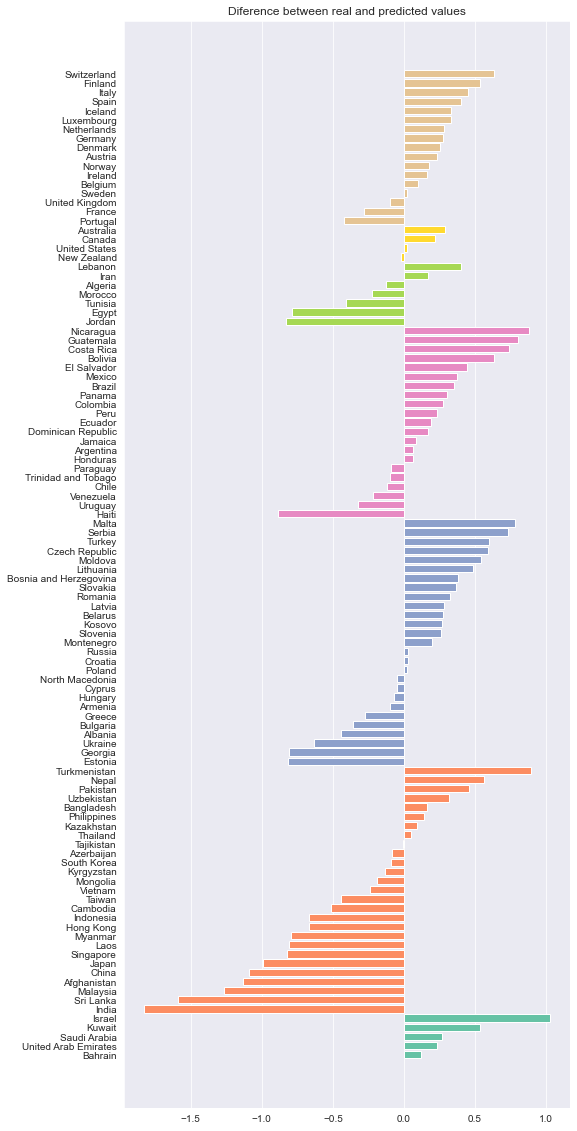

In [184]:
data_results.sort_values(by=['Region','dif'],inplace=True)

# Unique category labels: 'D', 'F', 'G', ...
color_labels = data_results.reset_index()['Region'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values

plt.figure(figsize=(8,20))
plt.barh(y=data_results.reset_index()['Country Name'],width=data_results['dif'],color=data_results.reset_index()['Region'].map(color_map))
plt.grid(axis='y')
plt.title('Diference between real and predicted values');

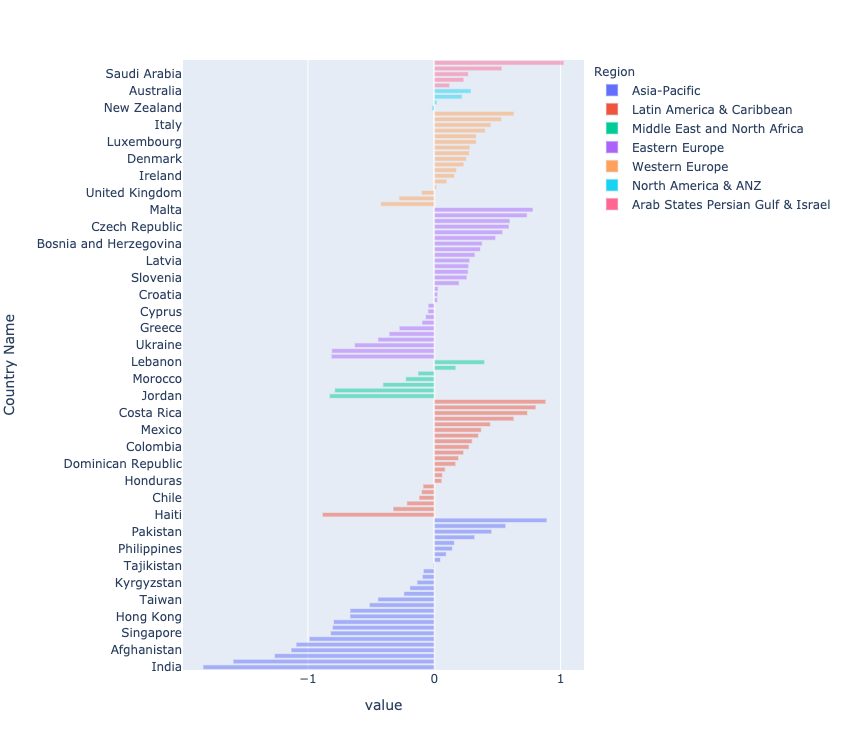

In [117]:

px.bar(data_results.reset_index(), y='Country Name',x=['dif'],
      orientation='h',barmode='overlay',height=750,width=700,color='Region',hover_data=['real'])

Finally, we check which are the countries that the model predicts with the most error, either positive or negative. 

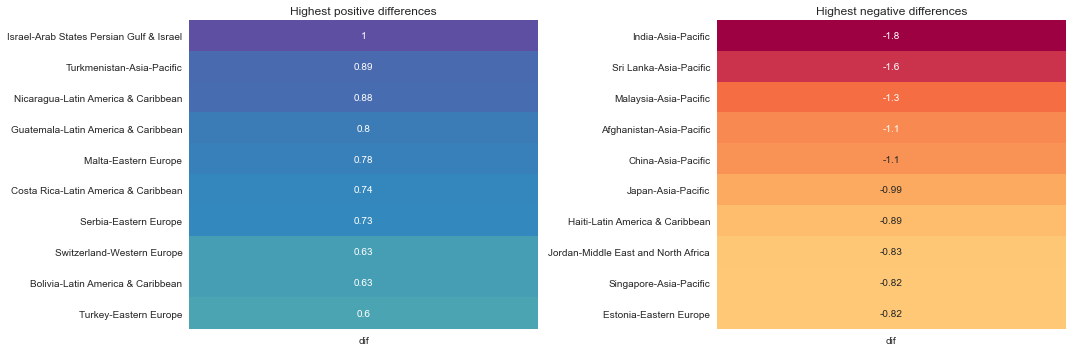

In [118]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(data_results[['dif']].sort_values(by='dif',ascending=False).head(10).round(2),
            annot=True, vmin=min(data_results['dif']),vmax=max(data_results['dif']),cmap='Spectral',
            cbar=False,ax=ax[0]);
ax[0].set(title='Highest positive differences',ylabel='')
sns.heatmap(data_results[['dif']].sort_values(by='dif').head(10).round(2),annot=True,
           vmin=min(data_results['dif']),vmax=max(data_results['dif']),cmap='Spectral',cbar=False,ax=ax[1])
ax[1].set(title='Highest negative differences',ylabel='')
plt.tight_layout()

<a id='conclusions'></a>
## Conclusions

The data shows that there is a relation between countries with a good performance in the economic freedom index and life ladder evaluations. As always, correlation does not mean causality, so this does not imply that economic freedom is the cause of happiness.

The inclusion of 'emotion' variables such as positive and negative affect is important for the predictions, since it takes into account subjective measures of well being that could explain cultural differences between societies. This seems to be the case in Latin America, which has higher life evaluations than those explained by an economic only model. Other regions like Western Europe, don't make much difference when we add positive and negative emotions in the model.

We also saw by clustering that the most prosperous countries, that are mainly located in Western Europe and North America & ANZ, have high Government effectiveness measured mainly by rule of law, open markets, and they can afford to have big government prescence, while mantaining fiscal health under control. 

Based on the evolution of life evaluations, Latin America and the Middle East / North Africa have a downward trend and also have a worse performance in the freedom index. On the other hand, Eastern Europe and Asia are improving on both fronts.